MONTAÑA RUSA 3D - PASO 1
Generación de trayectoria 3D mediante B-splines

CONSTRUYENDO: Montaña Rusa 3D - Diseño PDF
1. Sigmoide(A=100, m=0.5)
   Inicio: (0.0, 0.0, 100.0)
   Final:  (40.0, 0.0, 0.0)
   z_max: 100.0 m
2. Giro(R=20, α=90°)
   Inicio: (40.0, 0.0, 0.0)
   Final:  (60.0, 20.0, 0.0)
   z_max: 0.0 m
3. Clotoide(A=35, α=57.9°)
   Inicio: (60.0, 20.0, 0.0)
   Final:  (60.0, 66.4, 0.0)
   z_max: 16.6 m
4. Giro(R=25, α=90°)
   Inicio: (60.0, 66.4, 0.0)
   Final:  (35.0, 91.4, 0.0)
   z_max: 0.0 m
5. Gaussiana(A=30, s=20)
   Inicio: (35.0, 91.4, 0.0)
   Final:  (-69.0, 91.4, 0.0)
   z_max: 29.9 m
6. Giro(R=15, α=90°)
   Inicio: (-69.0, 91.4, 0.0)
   Final:  (-84.0, 76.4, 0.0)
   z_max: 0.0 m
7. Recta(L=30, m=0)
   Inicio: (-84.0, 76.4, 0.0)
   Final:  (-84.0, 46.4, 0.0)
   z_max: 0.0 m
----------------------------------------------------------------------
Longitud plano XY: 96.0 m
Altura máxima: 100.0 m
Puntos totales: 393

Figura guardada: montaña_rusa_3D.png


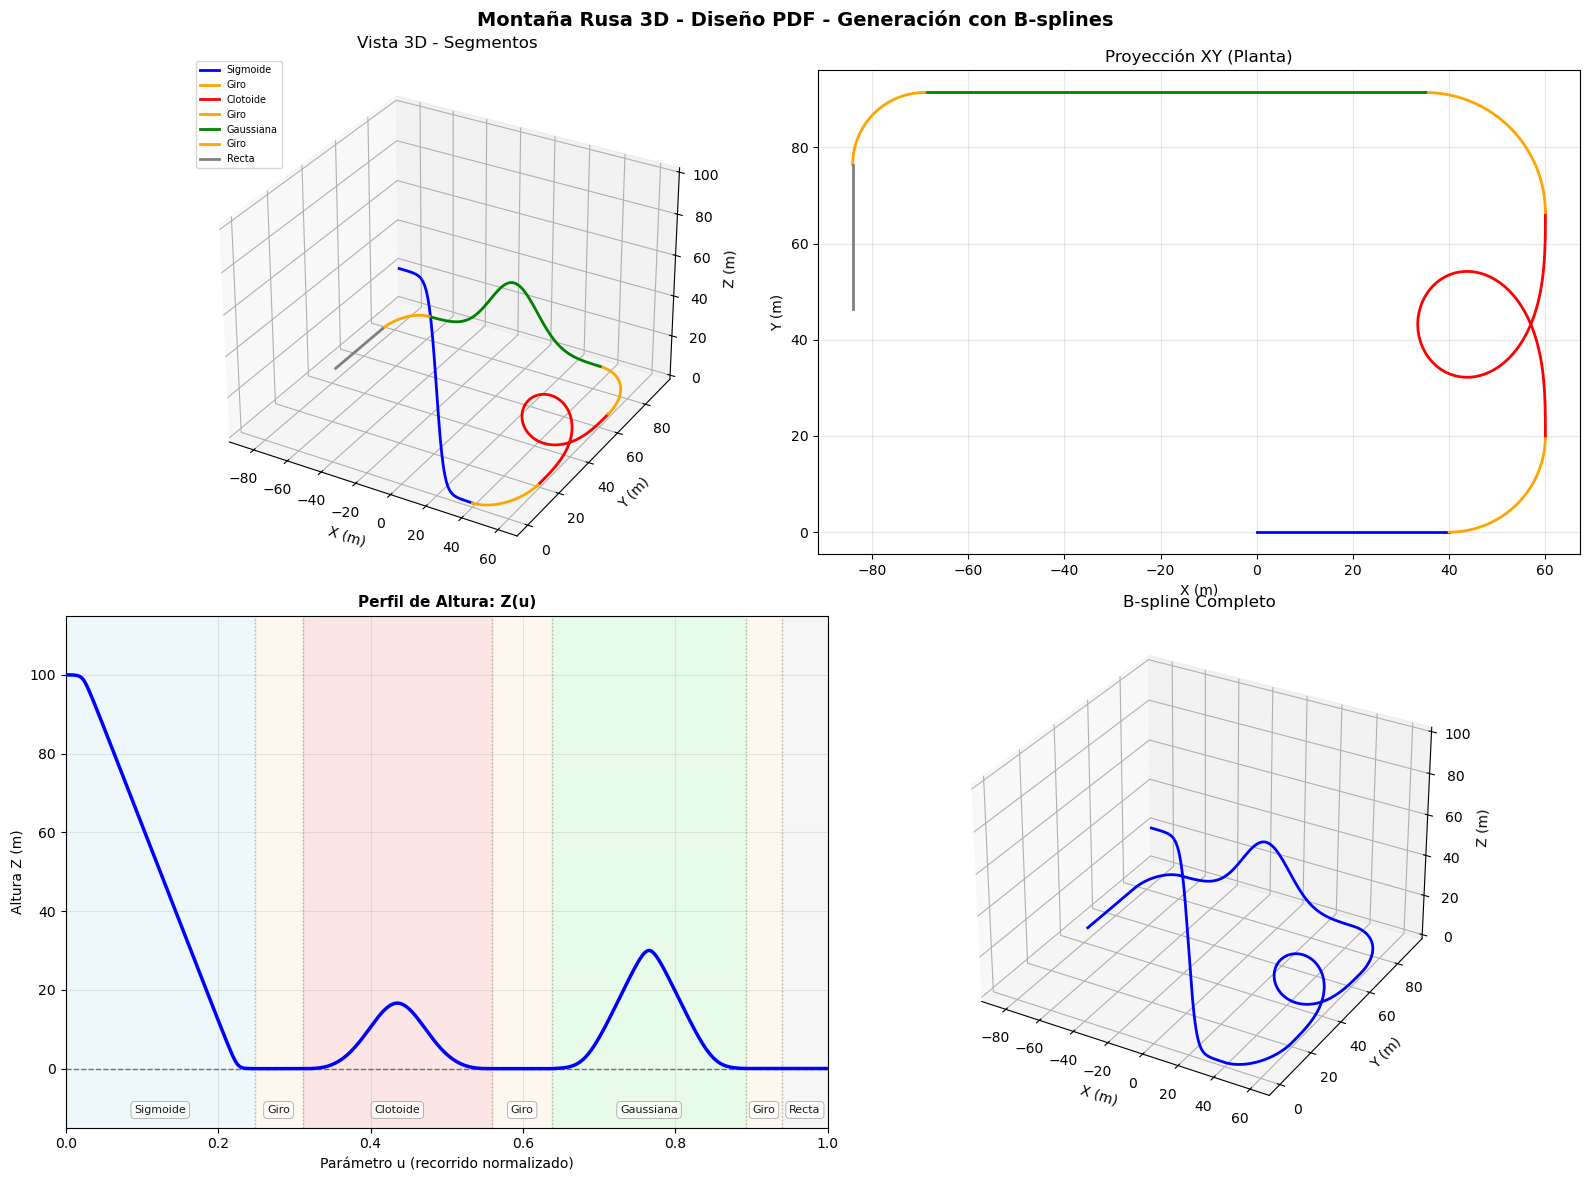


PASO 1 COMPLETADO - 3D

Elementos generados (3D):
  ✓ Descenso pronunciado (sigmoide)
  ✓ Giro circular 90° izquierda (R=20)
  ✓ Loop inclinado (clotoide α=arctan(√8/π))
  ✓ Giro circular 90° izquierda (R=25)
  ✓ Colina (gaussiana)
  ✓ Giro circular 90° izquierda (R=15)
  ✓ Recta final

El B-spline 3D está listo para simulación.
Uso: derivadas = mrusa.trayec_der(mr.bspline)



In [1]:
# -*- coding: utf-8 -*-
"""
Montaña Rusa 3D - Paso 1: Generación de la trayectoria mediante B-splines

Elementos constructivos según el PDF (página 12):
1. Descenso pronunciado (sigmoide)
2. Giro circular plano 90° izquierda (hélice α=0, R=20)
3. Loop (clotoide con α=arctan(√8/π))
4. Giro circular plano 90° izquierda (R=25)
5. Colina (campana de Gauss)
6. Giro circular plano 90° izquierda (R=15)
7. Recta final

La diferencia con 2D es que ahora trabajamos en XYZ, no solo XZ.
Los giros circulares planos permiten cambios de dirección horizontal.
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as scip
import scipy.integrate as scin
from mpl_toolkits.mplot3d import Axes3D

import pkgcurvas as curvas
import pkgmrusa as mrusa

# =============================================================================
# SEGMENTOS 3D
# =============================================================================

class Segmento3D:
    """Clase base para segmentos 3D de la montaña rusa"""
    def __init__(self, nombre, color='blue'):
        self.nombre = nombre
        self.color = color
        self.x, self.y, self.z = None, None, None
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        """
        Genera los puntos del segmento en 3D.
        
        Parámetros:
        -----------
        x0, y0, z0 : float - Punto inicial
        direccion_entrada : float - Ángulo de dirección en plano XY (radianes)
                            0=+X, π/2=+Y, π=-X, 3π/2=-Y
        n_puntos : int - Número de puntos a generar
        
        Retorna:
        --------
        x, y, z : arrays - Coordenadas del segmento
        direccion_salida : float - Ángulo de dirección al final
        """
        raise NotImplementedError
    
    def get_punto_final(self):
        """Retorna punto final (x, y, z)"""
        return self.x[-1], self.y[-1], self.z[-1]
    
    def get_direccion_final(self):
        """Retorna dirección final en radianes"""
        # Calcular del último segmento
        dx = self.x[-1] - self.x[-2]
        dy = self.y[-1] - self.y[-2]
        return np.arctan2(dy, dx)


class Sigmoide3D(Segmento3D):
    """
    Descenso pronunciado usando sigmoide.
    En 3D: sigue dirección inicial, solo cambia Z.
    """
    def __init__(self, A=100, m=0.5, u_min=-20, u_max=20, color='blue'):
        super().__init__(f'Sigmoide(A={A}, m={m})', color)
        self.A, self.m = A, m
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        
        # Generar perfil Z (sigmoide)
        _, z_sig = curvas.sigmoide(u, A=self.A, s=self.m)
        
        # Distancia recorrida en plano XY
        distancia = u - self.u_min
        
        # Proyectar en dirección actual
        self.x = x0 + distancia * np.cos(direccion_entrada)
        self.y = y0 + distancia * np.sin(direccion_entrada)
        self.z = z0 + z_sig
        
        return self.x, self.y, self.z, direccion_entrada


class GiroCircular3D(Segmento3D):
    """
    Giro circular horizontal (cambio de dirección en plano XY).
    Z puede variar (hélice) o mantenerse constante.
    """
    def __init__(self, R=20, angulo=np.pi/2, sentido='izquierda', 
                 variacion_z=0, color='orange'):
        """
        Parámetros:
        -----------
        R : float - Radio del giro
        angulo : float - Ángulo total a girar (radianes)
        sentido : str - 'izquierda' (+) o 'derecha' (-)
        variacion_z : float - Cambio en altura durante el giro (hélice)
        """
        super().__init__(f'Giro(R={R}, α={np.degrees(angulo):.0f}°)', color)
        self.R = R
        self.angulo = angulo
        self.sentido = sentido
        self.variacion_z = variacion_z
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        # Determinar sentido
        signo = 1 if self.sentido == 'izquierda' else -1
        
        # Centro del círculo (perpendicular a dirección de entrada)
        # Si vamos en dirección θ, el centro está a R en dirección θ±π/2
        angulo_centro = direccion_entrada + signo * np.pi/2
        cx = x0 + self.R * np.cos(angulo_centro)
        cy = y0 + self.R * np.sin(angulo_centro)
        
        # Generar puntos del arco
        # Ángulo inicial desde el centro
        theta_inicial = direccion_entrada - signo * np.pi/2
        theta = np.linspace(0, signo * self.angulo, n_puntos)
        
        self.x = cx + self.R * np.cos(theta_inicial + theta)
        self.y = cy + self.R * np.sin(theta_inicial + theta)
        self.z = z0 + self.variacion_z * (theta / (signo * self.angulo))
        
        direccion_salida = direccion_entrada + signo * self.angulo
        
        return self.x, self.y, self.z, direccion_salida


class Clotoide3D(Segmento3D):
    """
    Loop usando clotoide.
    Puede tener inclinación α en el plano vertical.
    """
    def __init__(self, A=35, alpha=0, color='red'):
        """
        Parámetros:
        -----------
        A : float - Amplitud de la clotoide
        alpha : float - Ángulo de inclinación del loop (radianes)
                        α=0 → loop vertical puro
                        α≠0 → loop inclinado
        """
        super().__init__(f'Clotoide(A={A}, α={np.degrees(alpha):.1f}°)', color)
        self.A = A
        self.alpha = alpha
        self.u_max = np.sqrt(np.pi)
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=80):
        u = np.linspace(0, self.u_max, n_puntos)
        
        # Generar clotoide en plano local
        x_local, z_local = curvas.clotoide(u, A=self.A, p0=0)
        
        # Crear loop completo (ida y vuelta)
        x_full = np.concatenate([x_local, 2*x_local[-1] - x_local[::-1][1:]])
        z_full = np.concatenate([z_local, z_local[::-1][1:]])
        
        # Rotar según inclinación α (en plano YZ local)
        # Si α≠0, parte de Z se proyecta en Y
        y_full = z_full * np.sin(self.alpha)
        z_full = z_full * np.cos(self.alpha)
        
        # Rotar según dirección de entrada
        cos_dir = np.cos(direccion_entrada)
        sin_dir = np.sin(direccion_entrada)
        
        x_rot = x_full * cos_dir - y_full * sin_dir
        y_rot = x_full * sin_dir + y_full * cos_dir
        
        # Trasladar a posición inicial
        self.x = x0 + x_rot
        self.y = y0 + y_rot
        self.z = z0 + z_full
        
        return self.x, self.y, self.z, direccion_entrada


class Gaussiana3D(Segmento3D):
    """Colina usando campana de Gauss."""
    def __init__(self, A=30, s=20, u_min=-52, u_max=52, color='green'):
        super().__init__(f'Gaussiana(A={A}, s={s})', color)
        self.A, self.s = A, s
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        
        # Generar perfil Z
        _, z_gauss = curvas.gausiana(u, A=self.A, s=self.s)
        
        # Distancia en plano XY
        distancia = u - self.u_min
        
        # Proyectar en dirección
        self.x = x0 + distancia * np.cos(direccion_entrada)
        self.y = y0 + distancia * np.sin(direccion_entrada)
        self.z = z0 + z_gauss
        
        return self.x, self.y, self.z, direccion_entrada


class Recta3D(Segmento3D):
    """Tramo recto en 3D."""
    def __init__(self, longitud=30, pendiente=0, color='gray'):
        super().__init__(f'Recta(L={longitud}, m={pendiente})', color)
        self.longitud = longitud
        self.pendiente = pendiente
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=20):
        u = np.linspace(0, self.longitud, n_puntos)
        
        self.x = x0 + u * np.cos(direccion_entrada)
        self.y = y0 + u * np.sin(direccion_entrada)
        self.z = z0 + self.pendiente * u
        
        return self.x, self.y, self.z, direccion_entrada


# =============================================================================
# CONSTRUCTOR DE MONTAÑA RUSA 3D
# =============================================================================

class MontañaRusa3D:
    """Constructor modular de montaña rusa 3D."""
    
    def __init__(self, nombre="Montaña Rusa 3D"):
        self.nombre = nombre
        self.segmentos = []
        self.x_total, self.y_total, self.z_total = None, None, None
        self.bspline = None
    
    def agregar(self, segmento):
        """Agrega un segmento."""
        self.segmentos.append(segmento)
        return self
    
    def construir(self, x0=0, y0=0, z0=0, dir0=0, n_puntos=50, verbose=True):
        """Construye la trayectoria 3D."""
        if verbose:
            print(f"\n{'='*70}")
            print(f"CONSTRUYENDO: {self.nombre}")
            print(f"{'='*70}")
        
        x_act, y_act, z_act = x0, y0, z0
        dir_act = dir0
        
        arrays_x, arrays_y, arrays_z = [], [], []
        
        for i, seg in enumerate(self.segmentos):
            x, y, z, dir_salida = seg.generar(x_act, y_act, z_act, dir_act, n_puntos)
            
            if verbose:
                print(f"{i+1}. {seg.nombre}")
                print(f"   Inicio: ({x[0]:.1f}, {y[0]:.1f}, {z[0]:.1f})")
                print(f"   Final:  ({x[-1]:.1f}, {y[-1]:.1f}, {z[-1]:.1f})")
                print(f"   z_max: {z.max():.1f} m")
            
            arrays_x.append(x if i == 0 else x[1:])
            arrays_y.append(y if i == 0 else y[1:])
            arrays_z.append(z if i == 0 else z[1:])
            
            x_act, y_act, z_act = seg.get_punto_final()
            dir_act = dir_salida
        
        self.x_total = np.concatenate(arrays_x)
        self.y_total = np.concatenate(arrays_y)
        self.z_total = np.concatenate(arrays_z)
        
        # Crear B-spline
        puntos_3d = np.array([self.x_total, self.y_total, self.z_total])
        tck, _ = scip.splprep(puntos_3d, s=0, k=3)
        t, c, k = tck
        self.bspline = scip.BSpline(t, np.array(c).T, k)
        
        if verbose:
            print(f"{'-'*70}")
            print(f"Longitud plano XY: {np.hypot(self.x_total[-1]-self.x_total[0], self.y_total[-1]-self.y_total[0]):.1f} m")
            print(f"Altura máxima: {self.z_total.max():.1f} m")
            print(f"Puntos totales: {len(self.x_total)}")
        
        return self
    
    def visualizar(self, guardar=False, archivo="montaña_rusa_3D.png"):
        """Genera visualización 3D."""
        fig = plt.figure(figsize=(16, 12))
        
        # Vista 3D principal
        ax1 = fig.add_subplot(2, 2, 1, projection='3d')
        for seg in self.segmentos:
            ax1.plot(seg.x, seg.y, seg.z, '-', color=seg.color, lw=2,
                    label=seg.nombre.split('(')[0])
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.set_zlabel('Z (m)')
        ax1.set_title('Vista 3D - Segmentos')
        ax1.legend(fontsize=7, loc='upper left')
        
        # Proyección XY (planta)
        ax2 = fig.add_subplot(2, 2, 2)
        for seg in self.segmentos:
            ax2.plot(seg.x, seg.y, '-', color=seg.color, lw=2)
        ax2.set_xlabel('X (m)')
        ax2.set_ylabel('Y (m)')
        ax2.set_title('Proyección XY (Planta)')
        ax2.set_aspect('equal', adjustable='box')
        ax2.grid(True, alpha=0.3)
        
        # Perfil de altura Z(u) - CORREGIDO DETECTANDO CAMBIOS EN LA CURVA
        ax3 = fig.add_subplot(2, 2, 3)
        u_fino = np.linspace(0, 1, 1000)
        pos = self.bspline(u_fino)
        z_fino = pos[:, 2]
        
        # NUEVO ENFOQUE: Detectar límites mirando la trayectoria real
        # Acumular longitud de cada segmento
        longitudes = []
        for seg in self.segmentos:
            dx = np.diff(seg.x)
            dy = np.diff(seg.y)
            dz = np.diff(seg.z)
            long_seg = np.sum(np.sqrt(dx**2 + dy**2 + dz**2))
            longitudes.append(long_seg)
        
        # Convertir a parámetro u proporcional
        long_total = sum(longitudes)
        limites_u = [0.0]
        u_acum = 0
        for long in longitudes[:-1]:  # Todos menos el último
            u_acum += long / long_total
            limites_u.append(u_acum)
        limites_u.append(1.0)
        
        # Dibujar franjas de fondo por segmento
        colores_fondo = {
            'Sigmoide': 'lightblue',
            'Giro': 'wheat',
            'Clotoide': 'lightcoral',
            'Gaussiana': 'lightgreen',
            'Recta': 'lightgray'
        }
        
        # Calcular ylim para posicionar etiquetas
        z_min, z_max = z_fino.min(), z_fino.max()
        margen = (z_max - z_min) * 0.15
        y_top = z_max + margen
        y_bottom = min(z_min - margen, -5)
        
        for i, seg in enumerate(self.segmentos):
            nombre_base = seg.nombre.split('(')[0]
            color_fondo = colores_fondo.get(nombre_base, 'white')
            
            u_inicio = limites_u[i]
            u_fin = limites_u[i+1]
            
            # Franja de color
            ax3.axvspan(u_inicio, u_fin, alpha=0.2, color=color_fondo, zorder=1)
            
            # Etiqueta centrada
            u_centro = (u_inicio + u_fin) / 2
            ax3.text(u_centro, y_bottom + margen*0.3, nombre_base, 
                    rotation=0, fontsize=8, ha='center', va='center', 
                    alpha=0.9, zorder=4, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                             edgecolor='gray', alpha=0.8, linewidth=0.5))
        
        # Dibujar curva Z(u) DESPUÉS para que quede encima
        ax3.plot(u_fino, z_fino, 'b-', lw=2.5, zorder=3)
        
        # Marcar las transiciones entre segmentos
        for u_lim in limites_u[1:-1]:
            ax3.axvline(u_lim, color='gray', ls=':', alpha=0.5, lw=1, zorder=2)
        
        ax3.set_xlabel('Parámetro u (recorrido normalizado)', fontsize=10)
        ax3.set_ylabel('Altura Z (m)', fontsize=10)
        ax3.set_title('Perfil de Altura: Z(u)', fontsize=11, fontweight='bold')
        ax3.grid(True, alpha=0.3, zorder=0)
        ax3.axhline(0, color='k', ls='--', alpha=0.5, lw=1, zorder=2)
        ax3.set_xlim(0, 1)
        ax3.set_ylim(y_bottom, y_top)
        
        # Vista 3D con B-spline
        ax4 = fig.add_subplot(2, 2, 4, projection='3d')
        ax4.plot(pos[:, 0], pos[:, 1], pos[:, 2], 'b-', lw=2)
        ax4.set_xlabel('X (m)')
        ax4.set_ylabel('Y (m)')
        ax4.set_zlabel('Z (m)')
        ax4.set_title('B-spline Completo')
        
        plt.suptitle(f'{self.nombre} - Generación con B-splines', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if guardar:
            plt.savefig(archivo, dpi=150, bbox_inches='tight')
            print(f"\nFigura guardada: {archivo}")
        
        plt.show()
        return fig


# =============================================================================
# MONTAÑA RUSA 3D SEGÚN EL PDF
# =============================================================================

def crear_montaña_rusa_pdf_3d():
    """
    Crea montaña rusa 3D según PDF (página 12):
    1. Descenso pronunciado (sigmoide)
    2. Giro 90° izquierda (R=20)
    3. Loop (clotoide con α=arctan(√8/π))
    4. Giro 90° izquierda (R=25)
    5. Colina (gaussiana)
    6. Giro 90° izquierda (R=15)
    7. Recta final
    """
    mr = MontañaRusa3D("Montaña Rusa 3D - Diseño PDF")
    
    # 1. Descenso
    mr.agregar(Sigmoide3D(A=100, m=0.5, u_min=-20, u_max=20))
    
    # 2. Giro 90° izquierda
    mr.agregar(GiroCircular3D(R=20, angulo=np.pi/2, sentido='izquierda'))
    
    # 3. Loop con inclinación
    alpha_loop = np.arctan(np.sqrt(8/np.pi))
    mr.agregar(Clotoide3D(A=35, alpha=alpha_loop))
    
    # 4. Giro 90° izquierda
    mr.agregar(GiroCircular3D(R=25, angulo=np.pi/2, sentido='izquierda'))
    
    # 5. Colina
    mr.agregar(Gaussiana3D(A=30, s=20, u_min=-52, u_max=52))
    
    # 6. Giro 90° izquierda
    mr.agregar(GiroCircular3D(R=15, angulo=np.pi/2, sentido='izquierda'))
    
    # 7. Recta final
    mr.agregar(Recta3D(longitud=30, pendiente=0))
    
    mr.construir(x0=0, y0=0, z0=0, dir0=0)
    
    return mr


# =============================================================================
# PROGRAMA PRINCIPAL
# =============================================================================

if __name__ == "__main__":
    print("="*70)
    print("MONTAÑA RUSA 3D - PASO 1")
    print("Generación de trayectoria 3D mediante B-splines")
    print("="*70)
    
    # Crear montaña rusa 3D
    mr = crear_montaña_rusa_pdf_3d()
    
    # Visualizar
    mr.visualizar(guardar=True)
    
    print("\n" + "="*70)
    print("PASO 1 COMPLETADO - 3D")
    print("="*70)
    print("""
Elementos generados (3D):
  ✓ Descenso pronunciado (sigmoide)
  ✓ Giro circular 90° izquierda (R=20)
  ✓ Loop inclinado (clotoide α=arctan(√8/π))
  ✓ Giro circular 90° izquierda (R=25)
  ✓ Colina (gaussiana)
  ✓ Giro circular 90° izquierda (R=15)
  ✓ Recta final

El B-spline 3D está listo para simulación.
Uso: derivadas = mrusa.trayec_der(mr.bspline)
""")

MONTAÑA RUSA 3D - PASO 2
Resolución EDO - Caso Conservativo

1. GENERANDO TRAYECTORIA 3D...

2. SIMULACIÓN CONSERVATIVA...

COMPARACIÓN DE MÉTODOS - CASO CONSERVATIVO 3D
Parámetros: v0=2.0 m/s, g=9.81 m/s², μ=0, ca=0
----------------------------------------------------------------------
Resolviendo con RK45... OK - 178 pasos, t_final=17.68s
Resolviendo con RK23... OK - 179 pasos, t_final=17.68s
Resolviendo con DOP853... OK - 178 pasos, t_final=17.68s
Resolviendo con Radau... OK - 179 pasos, t_final=17.68s
Resolviendo con BDF... OK - 182 pasos, t_final=17.71s
Resolviendo con LSODA... OK - 180 pasos, t_final=17.69s

TABLA RESUMEN DE RESULTADOS
Método        Pasos       ΔE_mín       ΔE_máx     ΔE_medio        σ(ΔE)
------------------------------------------------------------------------------------------
RK45            178     -1.0e-04     +7.7e-06     -2.6e-05     +3.9e-05
RK23            179     -1.4e-04     +2.9e-04     +2.2e-05     +8.7e-05
DOP853          178     -5.1e-06     +9.6e-

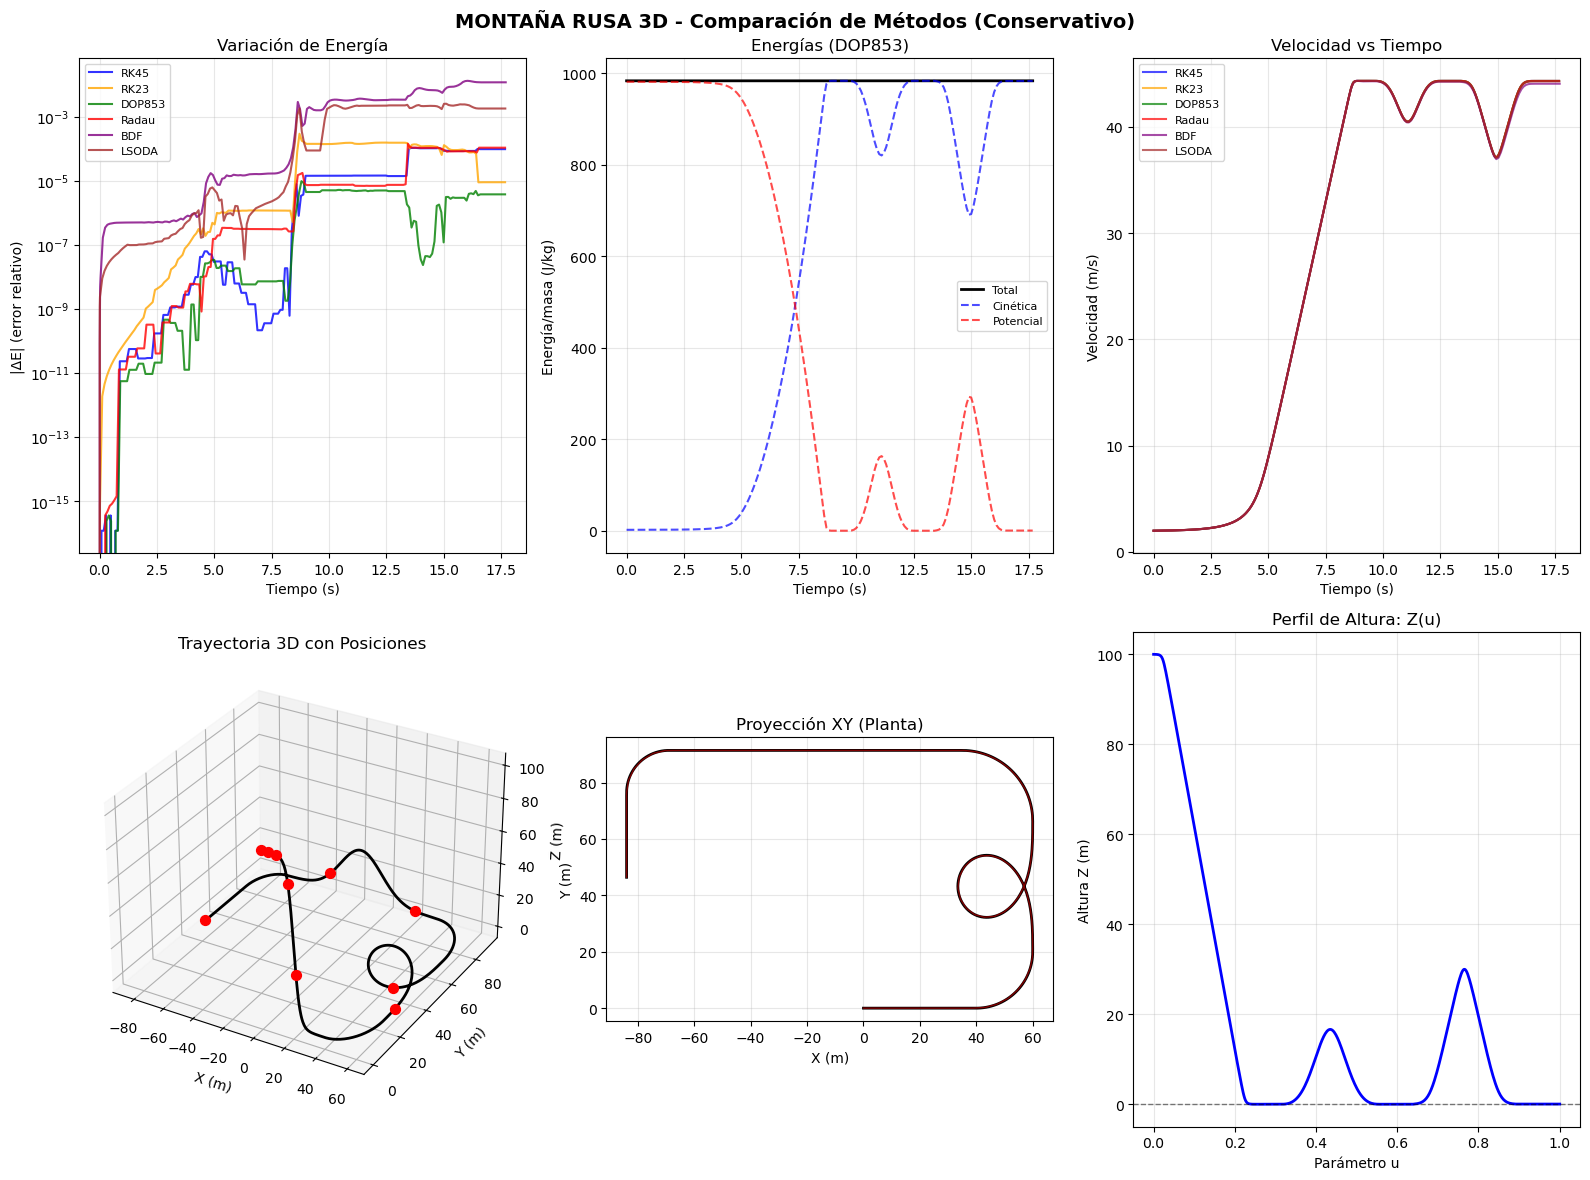


PASO 2 COMPLETADO - Método seleccionado: DOP853


In [2]:
# -*- coding: utf-8 -*-
"""
Montaña Rusa 3D - Paso 2: Resolución de la EDO en caso conservativo
Comparación de métodos numéricos: RK45, RK23, DOP853, Radau, BDF, LSODA

En el caso conservativo (μ=0, ca=0), la energía mecánica debe conservarse.
Esto permite evaluar la precisión de cada método midiendo la variación de energía.

DIFERENCIA CON 2D: La trayectoria es en XYZ, pero la física es la misma.
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as scip
import scipy.integrate as scin
from mpl_toolkits.mplot3d import Axes3D

import pkgcurvas as curvas
import pkgmrusa as mrusa

# =============================================================================
# PASO 1: RECREAR MONTAÑA RUSA 3D (del paso anterior)
# =============================================================================

class Segmento3D:
    def __init__(self, nombre, color='blue'):
        self.nombre = nombre
        self.color = color
        self.x, self.y, self.z = None, None, None
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        raise NotImplementedError
    
    def get_punto_final(self):
        return self.x[-1], self.y[-1], self.z[-1]
    
    def get_direccion_final(self):
        dx = self.x[-1] - self.x[-2]
        dy = self.y[-1] - self.y[-2]
        return np.arctan2(dy, dx)

class Sigmoide3D(Segmento3D):
    def __init__(self, A=100, m=0.5, u_min=-20, u_max=20, color='blue'):
        super().__init__(f'Sigmoide(A={A})', color)
        self.A, self.m = A, m
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        _, z_sig = curvas.sigmoide(u, A=self.A, s=self.m)
        distancia = u - self.u_min
        self.x = x0 + distancia * np.cos(direccion_entrada)
        self.y = y0 + distancia * np.sin(direccion_entrada)
        self.z = z0 + z_sig
        return self.x, self.y, self.z, direccion_entrada

class GiroCircular3D(Segmento3D):
    def __init__(self, R=20, angulo=np.pi/2, sentido='izquierda', variacion_z=0, color='orange'):
        super().__init__(f'Giro(R={R})', color)
        self.R, self.angulo = R, angulo
        self.sentido = sentido
        self.variacion_z = variacion_z
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        signo = 1 if self.sentido == 'izquierda' else -1
        angulo_centro = direccion_entrada + signo * np.pi/2
        cx = x0 + self.R * np.cos(angulo_centro)
        cy = y0 + self.R * np.sin(angulo_centro)
        theta_inicial = direccion_entrada - signo * np.pi/2
        theta = np.linspace(0, signo * self.angulo, n_puntos)
        self.x = cx + self.R * np.cos(theta_inicial + theta)
        self.y = cy + self.R * np.sin(theta_inicial + theta)
        self.z = z0 + self.variacion_z * (theta / (signo * self.angulo))
        direccion_salida = direccion_entrada + signo * self.angulo
        return self.x, self.y, self.z, direccion_salida

class Clotoide3D(Segmento3D):
    def __init__(self, A=35, alpha=0, color='red'):
        super().__init__(f'Clotoide(A={A})', color)
        self.A, self.alpha = A, alpha
        self.u_max = np.sqrt(np.pi)
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=80):
        u = np.linspace(0, self.u_max, n_puntos)
        x_local, z_local = curvas.clotoide(u, A=self.A, p0=0)
        x_full = np.concatenate([x_local, 2*x_local[-1] - x_local[::-1][1:]])
        z_full = np.concatenate([z_local, z_local[::-1][1:]])
        y_full = z_full * np.sin(self.alpha)
        z_full = z_full * np.cos(self.alpha)
        cos_dir, sin_dir = np.cos(direccion_entrada), np.sin(direccion_entrada)
        x_rot = x_full * cos_dir - y_full * sin_dir
        y_rot = x_full * sin_dir + y_full * cos_dir
        self.x = x0 + x_rot
        self.y = y0 + y_rot
        self.z = z0 + z_full
        return self.x, self.y, self.z, direccion_entrada

class Gaussiana3D(Segmento3D):
    def __init__(self, A=30, s=20, u_min=-52, u_max=52, color='green'):
        super().__init__(f'Gaussiana(A={A})', color)
        self.A, self.s = A, s
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        _, z_gauss = curvas.gausiana(u, A=self.A, s=self.s)
        distancia = u - self.u_min
        self.x = x0 + distancia * np.cos(direccion_entrada)
        self.y = y0 + distancia * np.sin(direccion_entrada)
        self.z = z0 + z_gauss
        return self.x, self.y, self.z, direccion_entrada

class Recta3D(Segmento3D):
    def __init__(self, longitud=30, pendiente=0, color='gray'):
        super().__init__(f'Recta(L={longitud})', color)
        self.longitud, self.pendiente = longitud, pendiente
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=20):
        u = np.linspace(0, self.longitud, n_puntos)
        self.x = x0 + u * np.cos(direccion_entrada)
        self.y = y0 + u * np.sin(direccion_entrada)
        self.z = z0 + self.pendiente * u
        return self.x, self.y, self.z, direccion_entrada

class MontañaRusa3D:
    def __init__(self, nombre="Montaña Rusa 3D"):
        self.nombre = nombre
        self.segmentos = []
        self.x_total, self.y_total, self.z_total = None, None, None
        self.bspline = None
    
    def agregar(self, segmento):
        self.segmentos.append(segmento)
        return self
    
    def construir(self, x0=0, y0=0, z0=0, dir0=0, n_puntos=50, verbose=False):
        x_act, y_act, z_act, dir_act = x0, y0, z0, dir0
        arrays_x, arrays_y, arrays_z = [], [], []
        for i, seg in enumerate(self.segmentos):
            x, y, z, dir_salida = seg.generar(x_act, y_act, z_act, dir_act, n_puntos)
            arrays_x.append(x if i == 0 else x[1:])
            arrays_y.append(y if i == 0 else y[1:])
            arrays_z.append(z if i == 0 else z[1:])
            x_act, y_act, z_act = seg.get_punto_final()
            dir_act = dir_salida
        self.x_total = np.concatenate(arrays_x)
        self.y_total = np.concatenate(arrays_y)
        self.z_total = np.concatenate(arrays_z)
        puntos_3d = np.array([self.x_total, self.y_total, self.z_total])
        tck, _ = scip.splprep(puntos_3d, s=0, k=3)
        t, c, k = tck
        self.bspline = scip.BSpline(t, np.array(c).T, k)
        return self

# =============================================================================
# PASO 2: SIMULADOR CONSERVATIVO 3D
# =============================================================================

class SimuladorConservativo3D:
    """
    Simulador 3D para caso conservativo.
    Las ecuaciones son las mismas que en 2D, solo cambia la trayectoria.
    """
    
    METODOS = ['RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']
    
    def __init__(self, montaña_rusa, v0=2.0, grav=9.81):
        self.mr = montaña_rusa
        self.v0, self.grav = v0, grav
        self.bspline = montaña_rusa.bspline
        self.derivadas = mrusa.trayec_der(self.bspline)
        self.resultados = {}
    
    def resolver(self, metodo, tfin=100, max_step=0.1):
        """Resuelve EDO en caso conservativo: μ=0, ca=0"""
        coefRoz, coefVis = 0.0, 0.0
        y0 = [0.0, self.v0]
        tspan = [0, tfin]
        
        sol = scin.solve_ivp(
            mrusa.edofun_mr, tspan, y0, method=metodo,
            args=[self.derivadas, coefRoz, coefVis, self.grav],
            events=[mrusa.finalVia, mrusa.paradaVagon],
            dense_output=True, max_step=max_step
        )
        return sol
    
    def calcular_energia(self, sol):
        """E_T = (1/2)v² + g·z"""
        t, u, v = sol.t, sol.y[0], sol.y[1]
        z = self.bspline(u)[:, 2]  # Componente Z del B-spline 3D
        E_cin = 0.5 * v**2
        E_pot = self.grav * z
        E_total = E_cin + E_pot
        return t, E_total, E_cin, E_pot
    
    def calcular_error_energia(self, E_total):
        """ΔE = (E₀ - E) / E₀"""
        E0 = E_total[0]
        return (E0 - E_total) / E0
    
    def comparar_metodos(self, verbose=True):
        if verbose:
            print("\n" + "="*70)
            print("COMPARACIÓN DE MÉTODOS - CASO CONSERVATIVO 3D")
            print("="*70)
            print(f"Parámetros: v0={self.v0} m/s, g={self.grav} m/s², μ=0, ca=0")
            print("-"*70)
        
        for metodo in self.METODOS:
            if verbose:
                print(f"Resolviendo con {metodo}...", end=" ")
            try:
                sol = self.resolver(metodo)
                t, E_total, E_cin, E_pot = self.calcular_energia(sol)
                error = self.calcular_error_energia(E_total)
                self.resultados[metodo] = {
                    'sol': sol, 't': t,
                    'E_total': E_total, 'E_cinetica': E_cin, 'E_potencial': E_pot,
                    'error': error, 'n_pasos': len(t), 'exito': sol.success
                }
                if verbose:
                    print(f"OK - {len(t)} pasos, t_final={t[-1]:.2f}s")
            except Exception as e:
                if verbose:
                    print(f"ERROR: {e}")
                self.resultados[metodo] = None
        return self.resultados
    
    def generar_tabla(self):
        print("\n" + "="*90)
        print("TABLA RESUMEN DE RESULTADOS")
        print("="*90)
        print(f"{'Método':<10} {'Pasos':>8} {'ΔE_mín':>12} {'ΔE_máx':>12} "
              f"{'ΔE_medio':>12} {'σ(ΔE)':>12}")
        print("-"*90)
        
        tabla = []
        for metodo in self.METODOS:
            res = self.resultados.get(metodo)
            if res is not None:
                error = res['error']
                fila = {
                    'metodo': metodo, 'pasos': res['n_pasos'],
                    'error_min': error.min(), 'error_max': error.max(),
                    'error_medio': error.mean(), 'error_std': error.std()
                }
                tabla.append(fila)
                print(f"{metodo:<10} {fila['pasos']:>8} {fila['error_min']:>+12.1e} "
                      f"{fila['error_max']:>+12.1e} {fila['error_medio']:>+12.1e} "
                      f"{fila['error_std']:>+12.1e}")
        
        print("-"*90)
        mejor = min(tabla, key=lambda x: x['error_std'])
        print(f"\n→ MEJOR MÉTODO: {mejor['metodo']} (σ(ΔE) = {mejor['error_std']:.1e})")
        self.tabla, self.mejor_metodo = tabla, mejor['metodo']
        return tabla
    
    def visualizar(self, guardar=True):
        fig = plt.figure(figsize=(16, 12))
        colores = {'RK45': 'blue', 'RK23': 'orange', 'DOP853': 'green',
                   'Radau': 'red', 'BDF': 'purple', 'LSODA': 'brown'}
        
        # 1. Error de energía
        ax1 = fig.add_subplot(2, 3, 1)
        for metodo, res in self.resultados.items():
            if res is not None:
                ax1.semilogy(res['t'], np.abs(res['error']), 
                            label=metodo, color=colores[metodo], alpha=0.8)
        ax1.set_xlabel('Tiempo (s)')
        ax1.set_ylabel('|ΔE| (error relativo)')
        ax1.set_title('Variación de Energía')
        ax1.legend(loc='best', fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # 2. Energías (mejor método)
        ax2 = fig.add_subplot(2, 3, 2)
        mejor = self.mejor_metodo
        if mejor in self.resultados:
            res = self.resultados[mejor]
            ax2.plot(res['t'], res['E_total'], 'k-', label='Total', lw=2)
            ax2.plot(res['t'], res['E_cinetica'], 'b--', label='Cinética', alpha=0.7)
            ax2.plot(res['t'], res['E_potencial'], 'r--', label='Potencial', alpha=0.7)
        ax2.set_xlabel('Tiempo (s)')
        ax2.set_ylabel('Energía/masa (J/kg)')
        ax2.set_title(f'Energías ({mejor})')
        ax2.legend(fontsize=8)
        ax2.grid(True, alpha=0.3)
        
        # 3. Velocidad vs tiempo
        ax3 = fig.add_subplot(2, 3, 3)
        for metodo, res in self.resultados.items():
            if res is not None:
                ax3.plot(res['t'], res['sol'].y[1], label=metodo, 
                        color=colores[metodo], alpha=0.7)
        ax3.set_xlabel('Tiempo (s)')
        ax3.set_ylabel('Velocidad (m/s)')
        ax3.set_title('Velocidad vs Tiempo')
        ax3.legend(loc='best', fontsize=8)
        ax3.grid(True, alpha=0.3)
        
        # 4. Trayectoria 3D
        ax4 = fig.add_subplot(2, 3, 4, projection='3d')
        u_curva = np.linspace(0, 1, 500)
        pos = self.bspline(u_curva)
        ax4.plot(pos[:, 0], pos[:, 1], pos[:, 2], 'k-', lw=2)
        if mejor in self.resultados:
            sol = self.resultados[mejor]['sol']
            t_marcas = np.linspace(0, sol.t[-1], 10)
            for t_m in t_marcas:
                u_m = sol.sol(t_m)[0]
                if 0 <= u_m <= 1:
                    p = self.bspline(u_m)
                    ax4.scatter(p[0], p[1], p[2], c='r', s=50)
        ax4.set_xlabel('X (m)')
        ax4.set_ylabel('Y (m)')
        ax4.set_zlabel('Z (m)')
        ax4.set_title('Trayectoria 3D con Posiciones')
        
        # 5. Proyección XY
        ax5 = fig.add_subplot(2, 3, 5)
        ax5.plot(pos[:, 0], pos[:, 1], 'k-', lw=2)
        if mejor in self.resultados:
            sol = self.resultados[mejor]['sol']
            u_tray = sol.y[0]
            pos_tray = self.bspline(u_tray[u_tray <= 1])
            ax5.plot(pos_tray[:, 0], pos_tray[:, 1], 'r-', alpha=0.5, lw=1)
        ax5.set_xlabel('X (m)')
        ax5.set_ylabel('Y (m)')
        ax5.set_title('Proyección XY (Planta)')
        ax5.set_aspect('equal', adjustable='box')
        ax5.grid(True, alpha=0.3)
        
        # 6. Perfil Z(u)
        ax6 = fig.add_subplot(2, 3, 6)
        ax6.plot(u_curva, pos[:, 2], 'b-', lw=2)
        ax6.set_xlabel('Parámetro u')
        ax6.set_ylabel('Altura Z (m)')
        ax6.set_title('Perfil de Altura: Z(u)')
        ax6.grid(True, alpha=0.3)
        ax6.axhline(0, color='k', ls='--', alpha=0.5, lw=1)
        
        plt.suptitle('MONTAÑA RUSA 3D - Comparación de Métodos (Conservativo)', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if guardar:
            plt.savefig('montaña_rusa_3D_paso2.png', dpi=150, bbox_inches='tight')
            print("\nFigura guardada: montaña_rusa_3D_paso2.png")
        
        plt.show()
        return fig

# =============================================================================
# PROGRAMA PRINCIPAL
# =============================================================================

if __name__ == "__main__":
    print("="*70)
    print("MONTAÑA RUSA 3D - PASO 2")
    print("Resolución EDO - Caso Conservativo")
    print("="*70)
    
    # 1. Crear montaña rusa 3D
    print("\n1. GENERANDO TRAYECTORIA 3D...")
    mr = MontañaRusa3D("Montaña Rusa 3D - PDF")
    mr.agregar(Sigmoide3D(A=100, m=0.5, u_min=-20, u_max=20))
    mr.agregar(GiroCircular3D(R=20, angulo=np.pi/2, sentido='izquierda'))
    mr.agregar(Clotoide3D(A=35, alpha=np.arctan(np.sqrt(8/np.pi))))
    mr.agregar(GiroCircular3D(R=25, angulo=np.pi/2, sentido='izquierda'))
    mr.agregar(Gaussiana3D(A=30, s=20, u_min=-52, u_max=52))
    mr.agregar(GiroCircular3D(R=15, angulo=np.pi/2, sentido='izquierda'))
    mr.agregar(Recta3D(longitud=30, pendiente=0))
    mr.construir()
    
    # 2. Simulación conservativa
    print("\n2. SIMULACIÓN CONSERVATIVA...")
    sim = SimuladorConservativo3D(mr, v0=2.0, grav=9.81)
    sim.comparar_metodos()
    sim.generar_tabla()
    
    # 3. Visualización
    print("\n3. GENERANDO VISUALIZACIÓN...")
    sim.visualizar(guardar=True)
    
    print("\n" + "="*70)
    print(f"PASO 2 COMPLETADO - Método seleccionado: {sim.mejor_metodo}")
    print("="*70)

MONTAÑA RUSA 3D - PASO 3
Simulación con Fricción y Arrastre

CONSTRUYENDO: Diseño PDF 3D
1. Sigmoide(A=100, m=0.5)
   z: [0.0, 100.0] m
2. Giro(R=20, α=90°)
   z: [0.0, 0.0] m
3. Clotoide(A=35, α=57.9°)
   z: [0.0, 16.6] m
4. Giro(R=25, α=90°)
   z: [0.0, 0.0] m
5. Gaussiana(A=30, s=20)
   z: [0.0, 29.9] m
6. Giro(R=15, α=90°)
   z: [0.0, 0.0] m
7. Recta(L=30, m=0)
   z: [0.0, 0.0] m
------------------------------------------------------------
Altura máxima: 100.0 m
Puntos: 393

Simulando con DOP853...
Parámetros: m=800kg, v0=2.0m/s, μ=0.015, ca=0.4, cv=6.13e-04

RESULTADOS DE LA SIMULACIÓN
Recorrido completado: 100.0%
Tiempo total: 21.80 s
Velocidad: [1.8, 42.1] m/s
Aceleración máxima: 33.9g
Fuerza normal: [-9.8, 340.6] m/s²

------------------------------------------------------------
ANÁLISIS DE VIABILIDAD
------------------------------------------------------------
✓ Completa el recorrido
✗ Aceleración excesiva: 33.9g (límite: 4.0g)
ℹ Fuerza normal negativa: up-stop wheels activas


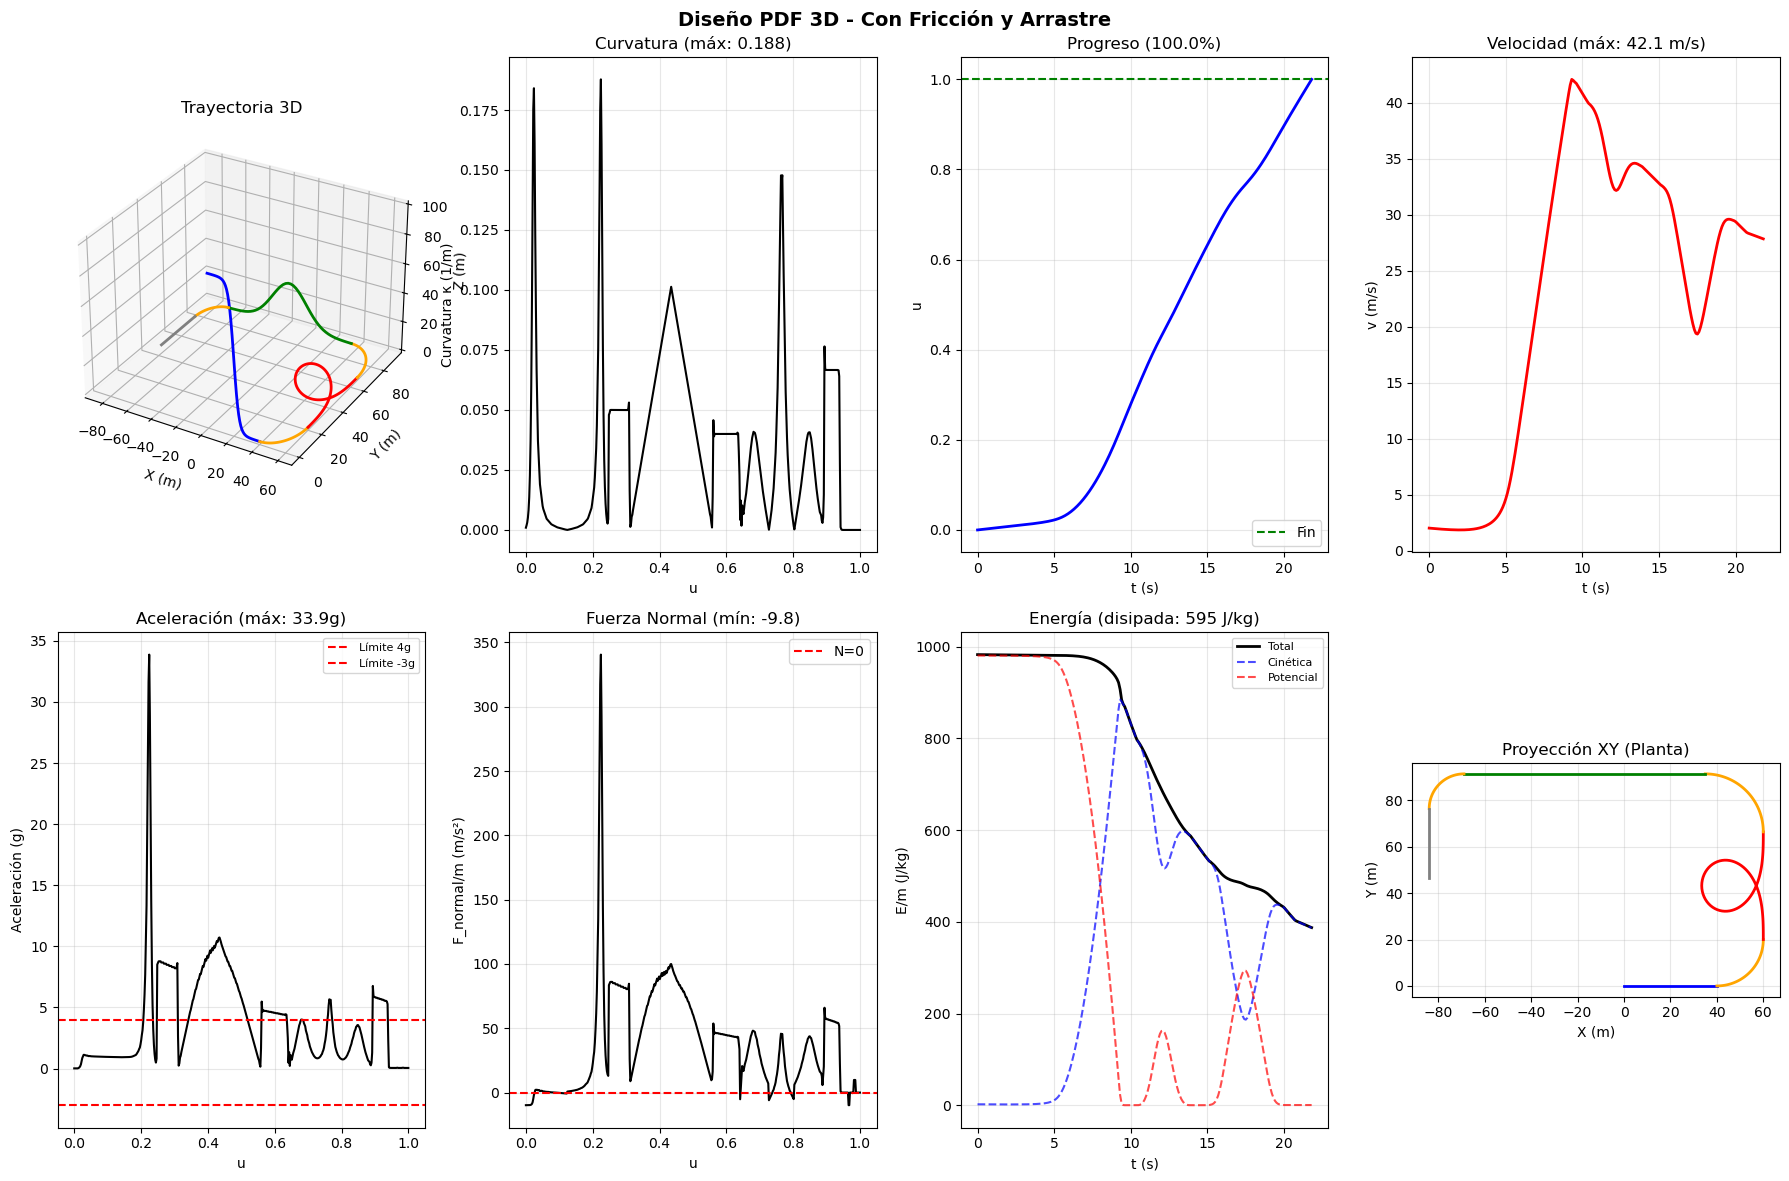


PASO 3 COMPLETADO

Si el diseño NO es viable, modificar parámetros:
  - Reducir pendiente: Sigmoide3D(m=0.3)  
  - Aumentar descenso: Sigmoide3D(A=120)
  - Reducir loop: Clotoide3D(A=30)
  - Reducir colina: Gaussiana3D(A=25)
  - Aumentar v0: ParametrosFisicos(v0=3.0)

Ejemplo diseño modificado:
  mr.agregar(Sigmoide3D(A=120, m=0.4))  ← Mayor energía inicial
  mr.agregar(Clotoide3D(A=30))          ← Loop más pequeño
  mr.agregar(Gaussiana3D(A=25))         ← Colina más baja



In [3]:
# -*- coding: utf-8 -*-
"""
Montaña Rusa 3D - Paso 3: Resolución con fricción y arrastre

Parámetros físicos (PDF página 6-7):
- Masa: m = 800 kg
- Fricción: μ = 0.015
- Arrastre: ca = 0.4
- Superficie: Sf = 2 m²
- Densidad aire: ρa = 1.225 kg/m³
- Velocidad inicial: v0 = 2 m/s

Límites UNE-EN 13814-1 Anexo I:
- Aceleración máxima: < 4g sostenida
- Aceleración negativa: > -3g
- Fuerza normal negativa: PERMITIDA (up-stop wheels)
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as scip
import scipy.integrate as scin
from mpl_toolkits.mplot3d import Axes3D

import pkgcurvas as curvas
import pkgmrusa as mrusa

# =============================================================================
# SEGMENTOS 3D MODULARES
# =============================================================================

class Segmento3D:
    def __init__(self, nombre, color='blue'):
        self.nombre = nombre
        self.color = color
        self.x, self.y, self.z = None, None, None
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        raise NotImplementedError
    
    def get_punto_final(self):
        return self.x[-1], self.y[-1], self.z[-1]

class Sigmoide3D(Segmento3D):
    def __init__(self, A=100, m=0.5, u_min=-20, u_max=20, color='blue'):
        super().__init__(f'Sigmoide(A={A}, m={m})', color)
        self.A, self.m = A, m
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        _, z_sig = curvas.sigmoide(u, A=self.A, s=self.m)
        distancia = u - self.u_min
        self.x = x0 + distancia * np.cos(direccion_entrada)
        self.y = y0 + distancia * np.sin(direccion_entrada)
        self.z = z0 + z_sig
        return self.x, self.y, self.z, direccion_entrada

class GiroCircular3D(Segmento3D):
    def __init__(self, R=20, angulo=np.pi/2, sentido='izquierda', variacion_z=0, color='orange'):
        super().__init__(f'Giro(R={R}, α={np.degrees(angulo):.0f}°)', color)
        self.R, self.angulo = R, angulo
        self.sentido = sentido
        self.variacion_z = variacion_z
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        signo = 1 if self.sentido == 'izquierda' else -1
        angulo_centro = direccion_entrada + signo * np.pi/2
        cx = x0 + self.R * np.cos(angulo_centro)
        cy = y0 + self.R * np.sin(angulo_centro)
        theta_inicial = direccion_entrada - signo * np.pi/2
        theta = np.linspace(0, signo * self.angulo, n_puntos)
        self.x = cx + self.R * np.cos(theta_inicial + theta)
        self.y = cy + self.R * np.sin(theta_inicial + theta)
        self.z = z0 + self.variacion_z * (theta / (signo * self.angulo))
        direccion_salida = direccion_entrada + signo * self.angulo
        return self.x, self.y, self.z, direccion_salida

class Clotoide3D(Segmento3D):
    def __init__(self, A=35, alpha=0, color='red'):
        super().__init__(f'Clotoide(A={A}, α={np.degrees(alpha):.1f}°)', color)
        self.A, self.alpha = A, alpha
        self.u_max = np.sqrt(np.pi)
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=80):
        u = np.linspace(0, self.u_max, n_puntos)
        x_local, z_local = curvas.clotoide(u, A=self.A, p0=0)
        x_full = np.concatenate([x_local, 2*x_local[-1] - x_local[::-1][1:]])
        z_full = np.concatenate([z_local, z_local[::-1][1:]])
        y_full = z_full * np.sin(self.alpha)
        z_full = z_full * np.cos(self.alpha)
        cos_dir, sin_dir = np.cos(direccion_entrada), np.sin(direccion_entrada)
        x_rot = x_full * cos_dir - y_full * sin_dir
        y_rot = x_full * sin_dir + y_full * cos_dir
        self.x = x0 + x_rot
        self.y = y0 + y_rot
        self.z = z0 + z_full
        return self.x, self.y, self.z, direccion_entrada

class Gaussiana3D(Segmento3D):
    def __init__(self, A=30, s=20, u_min=-52, u_max=52, color='green'):
        super().__init__(f'Gaussiana(A={A}, s={s})', color)
        self.A, self.s = A, s
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        _, z_gauss = curvas.gausiana(u, A=self.A, s=self.s)
        distancia = u - self.u_min
        self.x = x0 + distancia * np.cos(direccion_entrada)
        self.y = y0 + distancia * np.sin(direccion_entrada)
        self.z = z0 + z_gauss
        return self.x, self.y, self.z, direccion_entrada

class Recta3D(Segmento3D):
    def __init__(self, longitud=30, pendiente=0, color='gray'):
        super().__init__(f'Recta(L={longitud}, m={pendiente})', color)
        self.longitud, self.pendiente = longitud, pendiente
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=20):
        u = np.linspace(0, self.longitud, n_puntos)
        self.x = x0 + u * np.cos(direccion_entrada)
        self.y = y0 + u * np.sin(direccion_entrada)
        self.z = z0 + self.pendiente * u
        return self.x, self.y, self.z, direccion_entrada

# =============================================================================
# MONTAÑA RUSA 3D
# =============================================================================

class MontañaRusa3D:
    """Constructor modular de montaña rusa 3D."""
    
    def __init__(self, nombre="Montaña Rusa 3D"):
        self.nombre = nombre
        self.segmentos = []
        self.x_total, self.y_total, self.z_total = None, None, None
        self.bspline = None
    
    def agregar(self, segmento):
        self.segmentos.append(segmento)
        return self
    
    def construir(self, x0=0, y0=0, z0=0, dir0=0, n_puntos=50, verbose=True):
        if verbose:
            print(f"\n{'='*60}")
            print(f"CONSTRUYENDO: {self.nombre}")
            print(f"{'='*60}")
        
        x_act, y_act, z_act, dir_act = x0, y0, z0, dir0
        arrays_x, arrays_y, arrays_z = [], [], []
        
        for i, seg in enumerate(self.segmentos):
            x, y, z, dir_salida = seg.generar(x_act, y_act, z_act, dir_act, n_puntos)
            
            if verbose:
                print(f"{i+1}. {seg.nombre}")
                print(f"   z: [{z.min():.1f}, {z.max():.1f}] m")
            
            arrays_x.append(x if i == 0 else x[1:])
            arrays_y.append(y if i == 0 else y[1:])
            arrays_z.append(z if i == 0 else z[1:])
            
            x_act, y_act, z_act = seg.get_punto_final()
            dir_act = dir_salida
        
        self.x_total = np.concatenate(arrays_x)
        self.y_total = np.concatenate(arrays_y)
        self.z_total = np.concatenate(arrays_z)
        
        puntos_3d = np.array([self.x_total, self.y_total, self.z_total])
        tck, _ = scip.splprep(puntos_3d, s=0, k=3)
        t, c, k = tck
        self.bspline = scip.BSpline(t, np.array(c).T, k)
        
        if verbose:
            print(f"{'-'*60}")
            print(f"Altura máxima: {self.z_total.max():.1f} m")
            print(f"Puntos: {len(self.x_total)}")
        
        return self

# =============================================================================
# PARÁMETROS FÍSICOS
# =============================================================================

class ParametrosFisicos:
    def __init__(self, masa=800, v0=2.0, mu=0.015, ca=0.4, 
                 Sf=2.0, rho_a=1.225, grav=9.81):
        self.masa, self.v0, self.mu = masa, v0, mu
        self.ca, self.Sf, self.rho_a, self.grav = ca, Sf, rho_a, grav
        self.cv = ca * Sf * rho_a / (2 * masa)
    
    def __str__(self):
        return (f"m={self.masa}kg, v0={self.v0}m/s, μ={self.mu}, "
                f"ca={self.ca}, cv={self.cv:.2e}")

# =============================================================================
# SIMULADOR 3D
# =============================================================================

class Simulador3D:
    """Simulador 3D con fricción y arrastre."""
    
    ACEL_MAX_POSITIVA = 4.0   # g (UNE-EN 13814-1)
    ACEL_MAX_NEGATIVA = -3.0  # g
    ACEL_SOSTENIDA = 4.0      # g
    TIEMPO_SOSTENIDA = 4.0    # s
    
    def __init__(self, montaña_rusa, params=None):
        self.mr = montaña_rusa
        self.params = params or ParametrosFisicos()
        self.bspline = montaña_rusa.bspline
        self.derivadas = mrusa.trayec_der(self.bspline)
        self.sol = None
        self.datos = None
    
    def simular(self, metodo='DOP853', tfin=200, verbose=True):
        if verbose:
            print(f"\nSimulando con {metodo}...")
            print(f"Parámetros: {self.params}")
        
        self.sol = scin.solve_ivp(
            mrusa.edofun_mr, [0, tfin], [0.0, self.params.v0],
            method=metodo,
            args=[self.derivadas, self.params.mu, self.params.cv, self.params.grav],
            events=[mrusa.finalVia, mrusa.paradaVagon],
            dense_output=True, max_step=0.1
        )
        
        self._calcular_datos()
        
        if verbose:
            self._mostrar_resultados()
        
        return self
    
    def _calcular_datos(self):
        u, v, t = self.sol.y[0], self.sol.y[1], self.sol.t
        u_max = min(u[-1], 1.0)
        u_eval = np.linspace(0, u_max, 500)
        
        acel_total, acel_tang, acel_normal = [], [], []
        fuerza_normal, tiempos, velocidades, curvaturas = [], [], [], []
        
        for u_i in u_eval:
            idx = np.argmin(np.abs(u - u_i))
            v_i, t_i = v[idx], t[idx]
            try:
                fN, base, ctes = mrusa.fuerzaNormal(u_i, v_i, self.derivadas, self.params.grav)
                acel = mrusa.aceleracion(v_i, base, self.params.mu, self.params.cv,
                                        fN, ctes[1], self.params.grav)
                acel_total.append(acel[0])
                acel_tang.append(acel[1])
                acel_normal.append(acel[2])
                fuerza_normal.append(fN)
                curvaturas.append(ctes[1])
            except:
                acel_total.append(0)
                acel_tang.append(0)
                acel_normal.append(0)
                fuerza_normal.append(0)
                curvaturas.append(0)
            tiempos.append(t_i)
            velocidades.append(v_i)
        
        self.datos = {
            'u': u_eval, 't': np.array(tiempos), 'v': np.array(velocidades),
            'acel_total': np.array(acel_total), 'acel_tang': np.array(acel_tang),
            'acel_normal': np.array(acel_normal), 'fuerza_normal': np.array(fuerza_normal),
            'curvatura': np.array(curvaturas)
        }
    
    def _mostrar_resultados(self):
        u_final = self.sol.y[0][-1]
        v, g = self.sol.y[1], self.params.grav
        
        print(f"\n{'='*60}")
        print("RESULTADOS DE LA SIMULACIÓN")
        print(f"{'='*60}")
        print(f"Recorrido completado: {u_final*100:.1f}%")
        print(f"Tiempo total: {self.sol.t[-1]:.2f} s")
        print(f"Velocidad: [{v.min():.1f}, {v.max():.1f}] m/s")
        print(f"Aceleración máxima: {self.datos['acel_total'].max()/g:.1f}g")
        print(f"Fuerza normal: [{self.datos['fuerza_normal'].min():.1f}, "
              f"{self.datos['fuerza_normal'].max():.1f}] m/s²")
        
        print(f"\n{'-'*60}")
        print("ANÁLISIS DE VIABILIDAD")
        print(f"{'-'*60}")
        
        viable = True
        
        if u_final < 0.99:
            viable = False
            pos = self.bspline(u_final)
            print(f"✗ NO COMPLETA: u={u_final:.3f} (x={pos[0]:.1f}, y={pos[1]:.1f}, z={pos[2]:.1f})")
        else:
            print(f"✓ Completa el recorrido")
        
        acel_g = self.datos['acel_total'] / g
        if acel_g.max() > self.ACEL_MAX_POSITIVA:
            viable = False
            print(f"✗ Aceleración excesiva: {acel_g.max():.1f}g (límite: {self.ACEL_MAX_POSITIVA}g)")
        
        acel_n_g = self.datos['acel_normal'] / g
        if acel_n_g.min() < self.ACEL_MAX_NEGATIVA:
            viable = False
            print(f"✗ Aceleración negativa excesiva: {acel_n_g.min():.1f}g")
        
        if self.datos['fuerza_normal'].min() < 0:
            print(f"ℹ Fuerza normal negativa: up-stop wheels activas")
        
        print(f"\n→ VIABLE: {'SÍ' if viable else 'NO'}")
        return viable
    
    def visualizar(self, guardar=True, archivo="mr3d_paso3.png"):
        fig = plt.figure(figsize=(18, 12))
        t, u, v, g = self.sol.t, self.sol.y[0], self.sol.y[1], self.params.grav
        
        # 1. Trayectoria 3D
        ax1 = fig.add_subplot(2, 4, 1, projection='3d')
        for seg in self.mr.segmentos:
            ax1.plot(seg.x, seg.y, seg.z, '-', color=seg.color, lw=2)
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.set_zlabel('Z (m)')
        ax1.set_title('Trayectoria 3D')
        
        # 2. Curvatura
        ax2 = fig.add_subplot(2, 4, 2)
        ax2.plot(self.datos['u'], self.datos['curvatura'], 'k-', lw=1.5)
        ax2.set_xlabel('u')
        ax2.set_ylabel('Curvatura κ (1/m)')
        ax2.set_title(f"Curvatura (máx: {self.datos['curvatura'].max():.3f})")
        ax2.grid(True, alpha=0.3)
        
        # 3. Progreso u(t)
        ax3 = fig.add_subplot(2, 4, 3)
        ax3.plot(t, u, 'b-', lw=2)
        ax3.axhline(1, color='g', ls='--', label='Fin')
        ax3.set_xlabel('t (s)')
        ax3.set_ylabel('u')
        ax3.set_title(f'Progreso ({u[-1]*100:.1f}%)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Velocidad
        ax4 = fig.add_subplot(2, 4, 4)
        ax4.plot(t, v, 'r-', lw=2)
        ax4.set_xlabel('t (s)')
        ax4.set_ylabel('v (m/s)')
        ax4.set_title(f'Velocidad (máx: {v.max():.1f} m/s)')
        ax4.grid(True, alpha=0.3)
        
        # 5. Aceleración
        ax5 = fig.add_subplot(2, 4, 5)
        acel_g = self.datos['acel_total'] / g
        ax5.plot(self.datos['u'], acel_g, 'k-', lw=1.5)
        ax5.axhline(4, color='r', ls='--', label='Límite 4g')
        ax5.axhline(-3, color='r', ls='--', label='Límite -3g')
        ax5.set_xlabel('u')
        ax5.set_ylabel('Aceleración (g)')
        ax5.set_title(f'Aceleración (máx: {acel_g.max():.1f}g)')
        ax5.legend(fontsize=8)
        ax5.grid(True, alpha=0.3)
        
        # 6. Fuerza normal
        ax6 = fig.add_subplot(2, 4, 6)
        fN = self.datos['fuerza_normal']
        ax6.plot(self.datos['u'], fN, 'k-', lw=1.5)
        ax6.axhline(0, color='r', ls='--', label='N=0')
        ax6.set_xlabel('u')
        ax6.set_ylabel('F_normal/m (m/s²)')
        ax6.set_title(f'Fuerza Normal (mín: {fN.min():.1f})')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        # 7. Energía
        ax7 = fig.add_subplot(2, 4, 7)
        z = self.bspline(u)[:, 2]
        E_cin, E_pot = 0.5 * v**2, g * z
        E_total = E_cin + E_pot
        ax7.plot(t, E_total, 'k-', lw=2, label='Total')
        ax7.plot(t, E_cin, 'b--', alpha=0.7, label='Cinética')
        ax7.plot(t, E_pot, 'r--', alpha=0.7, label='Potencial')
        ax7.set_xlabel('t (s)')
        ax7.set_ylabel('E/m (J/kg)')
        ax7.set_title(f'Energía (disipada: {E_total[0]-E_total[-1]:.0f} J/kg)')
        ax7.legend(fontsize=8)
        ax7.grid(True, alpha=0.3)
        
        # 8. Proyección XY
        ax8 = fig.add_subplot(2, 4, 8)
        for seg in self.mr.segmentos:
            ax8.plot(seg.x, seg.y, '-', color=seg.color, lw=2)
        ax8.set_xlabel('X (m)')
        ax8.set_ylabel('Y (m)')
        ax8.set_title('Proyección XY (Planta)')
        ax8.set_aspect('equal', adjustable='box')
        ax8.grid(True, alpha=0.3)
        
        plt.suptitle(f'{self.mr.nombre} - Con Fricción y Arrastre', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if guardar:
            plt.savefig(archivo, dpi=150, bbox_inches='tight')
            print(f"\nFigura guardada: {archivo}")
        
        plt.show()
        return fig

# =============================================================================
# PROGRAMA PRINCIPAL
# =============================================================================

if __name__ == "__main__":
    print("="*70)
    print("MONTAÑA RUSA 3D - PASO 3")
    print("Simulación con Fricción y Arrastre")
    print("="*70)
    
    # DISEÑO MODULAR - Fácil de ajustar
    mr = MontañaRusa3D("Diseño PDF 3D")
    
    # Elementos obligatorios del PDF
    mr.agregar(Sigmoide3D(A=100, m=0.5, u_min=-20, u_max=20))
    mr.agregar(GiroCircular3D(R=20, angulo=np.pi/2))
    mr.agregar(Clotoide3D(A=35, alpha=np.arctan(np.sqrt(8/np.pi))))
    mr.agregar(GiroCircular3D(R=25, angulo=np.pi/2))
    mr.agregar(Gaussiana3D(A=30, s=20, u_min=-52, u_max=52))
    mr.agregar(GiroCircular3D(R=15, angulo=np.pi/2))
    mr.agregar(Recta3D(longitud=30, pendiente=0))
    
    mr.construir()
    
    # Parámetros del PDF
    params = ParametrosFisicos()
    
    # Simular
    sim = Simulador3D(mr, params)
    sim.simular(metodo='DOP853')
    sim.visualizar()
    
    print("\n" + "="*70)
    print("PASO 3 COMPLETADO")
    print("="*70)
    print("""
Si el diseño NO es viable, modificar parámetros:
  - Reducir pendiente: Sigmoide3D(m=0.3)  
  - Aumentar descenso: Sigmoide3D(A=120)
  - Reducir loop: Clotoide3D(A=30)
  - Reducir colina: Gaussiana3D(A=25)
  - Aumentar v0: ParametrosFisicos(v0=3.0)

Ejemplo diseño modificado:
  mr.agregar(Sigmoide3D(A=120, m=0.4))  ← Mayor energía inicial
  mr.agregar(Clotoide3D(A=30))          ← Loop más pequeño
  mr.agregar(Gaussiana3D(A=25))         ← Colina más baja
""")

MONTAÑA RUSA 3D - PASO 3 (CON FRANJAS DE COLORES)
Simulación con Fricción y Arrastre

CONSTRUYENDO: Diseño PDF 3D
1. Sigmoide(A=100, m=0.5)
   z: [0.0, 100.0] m
2. Giro(R=20, α=90°)
   z: [0.0, 0.0] m
3. Clotoide(A=35, α=57.9°)
   z: [0.0, 16.6] m
4. Giro(R=25, α=90°)
   z: [0.0, 0.0] m
5. Gaussiana(A=30, s=20)
   z: [0.0, 29.9] m
6. Giro(R=15, α=90°)
   z: [0.0, 0.0] m
7. Recta(L=30, m=0)
   z: [0.0, 0.0] m
------------------------------------------------------------
Altura máxima: 100.0 m
Puntos: 393

Simulando con DOP853...
Parámetros: m=800kg, v0=2.0m/s, μ=0.015, ca=0.4, cv=6.13e-04

RESULTADOS DE LA SIMULACIÓN
Recorrido completado: 100.0%
Tiempo total: 21.80 s
Velocidad: [1.8, 42.1] m/s
Aceleración máxima: 33.9g
Fuerza normal: [-9.8, 340.6] m/s²

------------------------------------------------------------
ANÁLISIS DE VIABILIDAD
------------------------------------------------------------
✓ Completa el recorrido
✗ Aceleración excesiva: 33.9g (límite: 4.0g)
ℹ Fuerza normal negativa

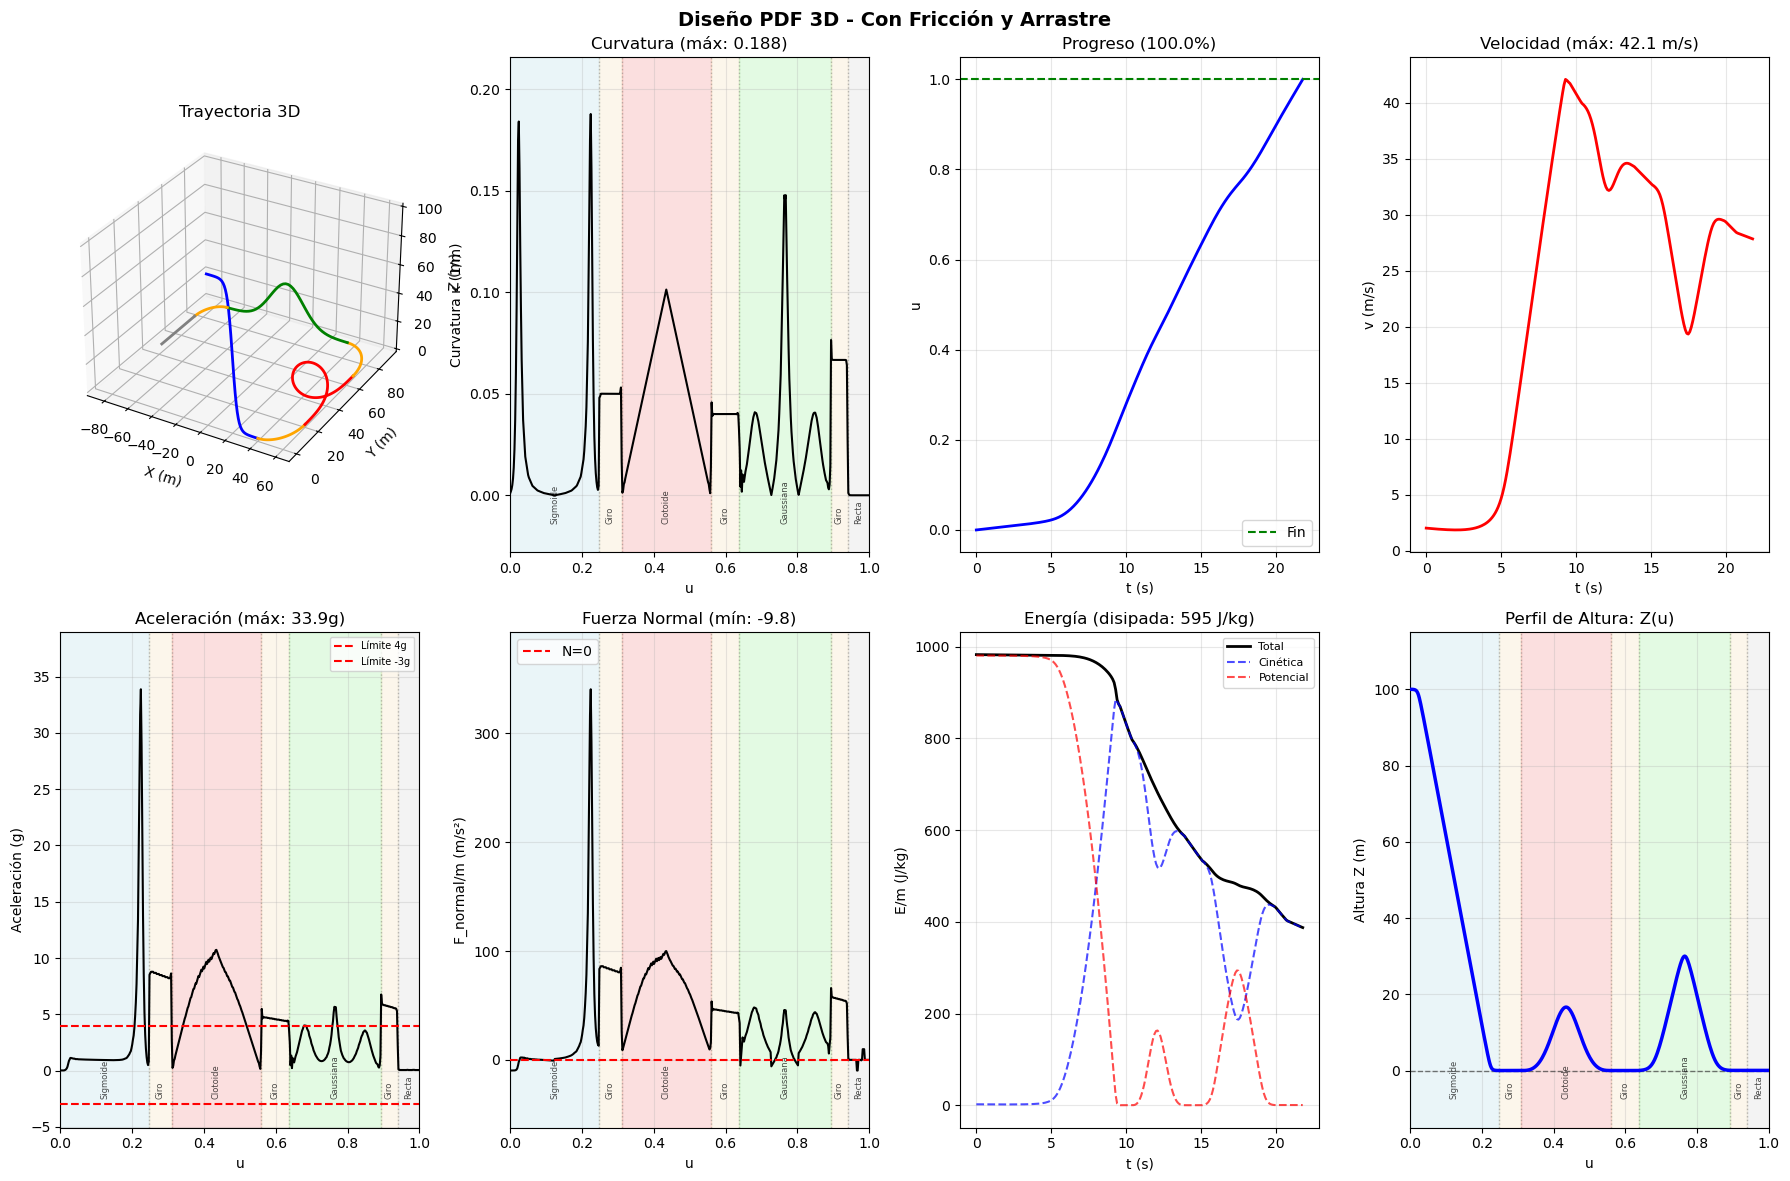


PASO 3 COMPLETADO


In [4]:
# -*- coding: utf-8 -*-
"""
Montaña Rusa 3D - Paso 3: Resolución con fricción y arrastre
CON FRANJAS DE COLORES POR SEGMENTO en gráficas de u
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as scip
import scipy.integrate as scin
from mpl_toolkits.mplot3d import Axes3D

import pkgcurvas as curvas
import pkgmrusa as mrusa

# =============================================================================
# SEGMENTOS 3D MODULARES
# =============================================================================

class Segmento3D:
    def __init__(self, nombre, color='blue'):
        self.nombre = nombre
        self.color = color
        self.x, self.y, self.z = None, None, None
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        raise NotImplementedError
    
    def get_punto_final(self):
        return self.x[-1], self.y[-1], self.z[-1]

class Sigmoide3D(Segmento3D):
    def __init__(self, A=100, m=0.5, u_min=-20, u_max=20, color='blue'):
        super().__init__(f'Sigmoide(A={A}, m={m})', color)
        self.A, self.m = A, m
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        _, z_sig = curvas.sigmoide(u, A=self.A, s=self.m)
        distancia = u - self.u_min
        self.x = x0 + distancia * np.cos(direccion_entrada)
        self.y = y0 + distancia * np.sin(direccion_entrada)
        self.z = z0 + z_sig
        return self.x, self.y, self.z, direccion_entrada

class GiroCircular3D(Segmento3D):
    def __init__(self, R=20, angulo=np.pi/2, sentido='izquierda', variacion_z=0, color='orange'):
        super().__init__(f'Giro(R={R}, α={np.degrees(angulo):.0f}°)', color)
        self.R, self.angulo = R, angulo
        self.sentido = sentido
        self.variacion_z = variacion_z
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        signo = 1 if self.sentido == 'izquierda' else -1
        angulo_centro = direccion_entrada + signo * np.pi/2
        cx = x0 + self.R * np.cos(angulo_centro)
        cy = y0 + self.R * np.sin(angulo_centro)
        theta_inicial = direccion_entrada - signo * np.pi/2
        theta = np.linspace(0, signo * self.angulo, n_puntos)
        self.x = cx + self.R * np.cos(theta_inicial + theta)
        self.y = cy + self.R * np.sin(theta_inicial + theta)
        self.z = z0 + self.variacion_z * (theta / (signo * self.angulo))
        direccion_salida = direccion_entrada + signo * self.angulo
        return self.x, self.y, self.z, direccion_salida

class Clotoide3D(Segmento3D):
    def __init__(self, A=35, alpha=0, color='red'):
        super().__init__(f'Clotoide(A={A}, α={np.degrees(alpha):.1f}°)', color)
        self.A, self.alpha = A, alpha
        self.u_max = np.sqrt(np.pi)
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=80):
        u = np.linspace(0, self.u_max, n_puntos)
        x_local, z_local = curvas.clotoide(u, A=self.A, p0=0)
        x_full = np.concatenate([x_local, 2*x_local[-1] - x_local[::-1][1:]])
        z_full = np.concatenate([z_local, z_local[::-1][1:]])
        y_full = z_full * np.sin(self.alpha)
        z_full = z_full * np.cos(self.alpha)
        cos_dir, sin_dir = np.cos(direccion_entrada), np.sin(direccion_entrada)
        x_rot = x_full * cos_dir - y_full * sin_dir
        y_rot = x_full * sin_dir + y_full * cos_dir
        self.x = x0 + x_rot
        self.y = y0 + y_rot
        self.z = z0 + z_full
        return self.x, self.y, self.z, direccion_entrada

class Gaussiana3D(Segmento3D):
    def __init__(self, A=30, s=20, u_min=-52, u_max=52, color='green'):
        super().__init__(f'Gaussiana(A={A}, s={s})', color)
        self.A, self.s = A, s
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        _, z_gauss = curvas.gausiana(u, A=self.A, s=self.s)
        distancia = u - self.u_min
        self.x = x0 + distancia * np.cos(direccion_entrada)
        self.y = y0 + distancia * np.sin(direccion_entrada)
        self.z = z0 + z_gauss
        return self.x, self.y, self.z, direccion_entrada

class Recta3D(Segmento3D):
    def __init__(self, longitud=30, pendiente=0, color='gray'):
        super().__init__(f'Recta(L={longitud}, m={pendiente})', color)
        self.longitud, self.pendiente = longitud, pendiente
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=20):
        u = np.linspace(0, self.longitud, n_puntos)
        self.x = x0 + u * np.cos(direccion_entrada)
        self.y = y0 + u * np.sin(direccion_entrada)
        self.z = z0 + self.pendiente * u
        return self.x, self.y, self.z, direccion_entrada

# =============================================================================
# MONTAÑA RUSA 3D
# =============================================================================

class MontañaRusa3D:
    def __init__(self, nombre="Montaña Rusa 3D"):
        self.nombre = nombre
        self.segmentos = []
        self.x_total, self.y_total, self.z_total = None, None, None
        self.bspline = None
        self.limites_u = None  # Guardar límites de segmentos
    
    def agregar(self, segmento):
        self.segmentos.append(segmento)
        return self
    
    def construir(self, x0=0, y0=0, z0=0, dir0=0, n_puntos=50, verbose=True):
        if verbose:
            print(f"\n{'='*60}")
            print(f"CONSTRUYENDO: {self.nombre}")
            print(f"{'='*60}")
        
        x_act, y_act, z_act, dir_act = x0, y0, z0, dir0
        arrays_x, arrays_y, arrays_z = [], [], []
        
        for i, seg in enumerate(self.segmentos):
            x, y, z, dir_salida = seg.generar(x_act, y_act, z_act, dir_act, n_puntos)
            
            if verbose:
                print(f"{i+1}. {seg.nombre}")
                print(f"   z: [{z.min():.1f}, {z.max():.1f}] m")
            
            arrays_x.append(x if i == 0 else x[1:])
            arrays_y.append(y if i == 0 else y[1:])
            arrays_z.append(z if i == 0 else z[1:])
            
            x_act, y_act, z_act = seg.get_punto_final()
            dir_act = dir_salida
        
        self.x_total = np.concatenate(arrays_x)
        self.y_total = np.concatenate(arrays_y)
        self.z_total = np.concatenate(arrays_z)
        
        puntos_3d = np.array([self.x_total, self.y_total, self.z_total])
        tck, _ = scip.splprep(puntos_3d, s=0, k=3)
        t, c, k = tck
        self.bspline = scip.BSpline(t, np.array(c).T, k)
        
        # Calcular límites de u para cada segmento
        self._calcular_limites_u()
        
        if verbose:
            print(f"{'-'*60}")
            print(f"Altura máxima: {self.z_total.max():.1f} m")
            print(f"Puntos: {len(self.x_total)}")
        
        return self
    
    def _calcular_limites_u(self):
        """Calcula los límites de u basándose en la longitud de arco de cada segmento."""
        longitudes = []
        for seg in self.segmentos:
            dx = np.diff(seg.x)
            dy = np.diff(seg.y)
            dz = np.diff(seg.z)
            long_seg = np.sum(np.sqrt(dx**2 + dy**2 + dz**2))
            longitudes.append(long_seg)
        
        long_total = sum(longitudes)
        self.limites_u = [0.0]
        u_acum = 0
        for long in longitudes[:-1]:
            u_acum += long / long_total
            self.limites_u.append(u_acum)
        self.limites_u.append(1.0)

# =============================================================================
# PARÁMETROS FÍSICOS
# =============================================================================

class ParametrosFisicos:
    def __init__(self, masa=800, v0=2.0, mu=0.015, ca=0.4, 
                 Sf=2.0, rho_a=1.225, grav=9.81):
        self.masa, self.v0, self.mu = masa, v0, mu
        self.ca, self.Sf, self.rho_a, self.grav = ca, Sf, rho_a, grav
        self.cv = ca * Sf * rho_a / (2 * masa)
    
    def __str__(self):
        return (f"m={self.masa}kg, v0={self.v0}m/s, μ={self.mu}, "
                f"ca={self.ca}, cv={self.cv:.2e}")

# =============================================================================
# SIMULADOR 3D CON VISUALIZACIÓN MEJORADA
# =============================================================================

class Simulador3D:
    """Simulador 3D con fricción y arrastre - Visualización con franjas de colores."""
    
    ACEL_MAX_POSITIVA = 4.0   # g (UNE-EN 13814-1)
    ACEL_MAX_NEGATIVA = -3.0  # g
    
    # Colores de fondo para cada tipo de segmento
    COLORES_FONDO = {
        'Sigmoide': 'lightblue',
        'Giro': 'wheat',
        'Clotoide': 'lightcoral',
        'Gaussiana': 'lightgreen',
        'Recta': 'lightgray'
    }
    
    def __init__(self, montaña_rusa, params=None):
        self.mr = montaña_rusa
        self.params = params or ParametrosFisicos()
        self.bspline = montaña_rusa.bspline
        self.derivadas = mrusa.trayec_der(self.bspline)
        self.sol = None
        self.datos = None
    
    def simular(self, metodo='DOP853', tfin=200, verbose=True):
        if verbose:
            print(f"\nSimulando con {metodo}...")
            print(f"Parámetros: {self.params}")
        
        self.sol = scin.solve_ivp(
            mrusa.edofun_mr, [0, tfin], [0.0, self.params.v0],
            method=metodo,
            args=[self.derivadas, self.params.mu, self.params.cv, self.params.grav],
            events=[mrusa.finalVia, mrusa.paradaVagon],
            dense_output=True, max_step=0.1
        )
        
        self._calcular_datos()
        
        if verbose:
            self._mostrar_resultados()
        
        return self
    
    def _calcular_datos(self):
        u, v, t = self.sol.y[0], self.sol.y[1], self.sol.t
        u_max = min(u[-1], 1.0)
        u_eval = np.linspace(0, u_max, 500)
        
        acel_total, acel_tang, acel_normal = [], [], []
        fuerza_normal, tiempos, velocidades, curvaturas = [], [], [], []
        
        for u_i in u_eval:
            idx = np.argmin(np.abs(u - u_i))
            v_i, t_i = v[idx], t[idx]
            try:
                fN, base, ctes = mrusa.fuerzaNormal(u_i, v_i, self.derivadas, self.params.grav)
                acel = mrusa.aceleracion(v_i, base, self.params.mu, self.params.cv,
                                        fN, ctes[1], self.params.grav)
                acel_total.append(acel[0])
                acel_tang.append(acel[1])
                acel_normal.append(acel[2])
                fuerza_normal.append(fN)
                curvaturas.append(ctes[1])
            except:
                acel_total.append(0)
                acel_tang.append(0)
                acel_normal.append(0)
                fuerza_normal.append(0)
                curvaturas.append(0)
            tiempos.append(t_i)
            velocidades.append(v_i)
        
        self.datos = {
            'u': u_eval, 't': np.array(tiempos), 'v': np.array(velocidades),
            'acel_total': np.array(acel_total), 'acel_tang': np.array(acel_tang),
            'acel_normal': np.array(acel_normal), 'fuerza_normal': np.array(fuerza_normal),
            'curvatura': np.array(curvaturas)
        }
    
    def _mostrar_resultados(self):
        u_final = self.sol.y[0][-1]
        v, g = self.sol.y[1], self.params.grav
        
        print(f"\n{'='*60}")
        print("RESULTADOS DE LA SIMULACIÓN")
        print(f"{'='*60}")
        print(f"Recorrido completado: {u_final*100:.1f}%")
        print(f"Tiempo total: {self.sol.t[-1]:.2f} s")
        print(f"Velocidad: [{v.min():.1f}, {v.max():.1f}] m/s")
        print(f"Aceleración máxima: {self.datos['acel_total'].max()/g:.1f}g")
        print(f"Fuerza normal: [{self.datos['fuerza_normal'].min():.1f}, "
              f"{self.datos['fuerza_normal'].max():.1f}] m/s²")
        
        print(f"\n{'-'*60}")
        print("ANÁLISIS DE VIABILIDAD")
        print(f"{'-'*60}")
        
        viable = True
        
        if u_final < 0.99:
            viable = False
            pos = self.bspline(u_final)
            print(f"✗ NO COMPLETA: u={u_final:.3f} (x={pos[0]:.1f}, y={pos[1]:.1f}, z={pos[2]:.1f})")
        else:
            print(f"✓ Completa el recorrido")
        
        acel_g = self.datos['acel_total'] / g
        if acel_g.max() > self.ACEL_MAX_POSITIVA:
            viable = False
            print(f"✗ Aceleración excesiva: {acel_g.max():.1f}g (límite: {self.ACEL_MAX_POSITIVA}g)")
        
        acel_n_g = self.datos['acel_normal'] / g
        if acel_n_g.min() < self.ACEL_MAX_NEGATIVA:
            viable = False
            print(f"✗ Aceleración negativa excesiva: {acel_n_g.min():.1f}g")
        
        if self.datos['fuerza_normal'].min() < 0:
            print(f"ℹ Fuerza normal negativa: up-stop wheels activas")
        
        print(f"\n→ VIABLE: {'SÍ' if viable else 'NO'}")
        return viable
    
    def _añadir_franjas_segmentos(self, ax, y_data, mostrar_etiquetas=True):
        """Añade franjas de colores de fondo para cada segmento en gráficas con abscisa u."""
        limites_u = self.mr.limites_u
        
        # Calcular límites verticales
        y_min, y_max = y_data.min(), y_data.max()
        margen = (y_max - y_min) * 0.15 if y_max != y_min else 1
        y_bottom = y_min - margen
        y_top = y_max + margen
        
        for i, seg in enumerate(self.mr.segmentos):
            nombre_base = seg.nombre.split('(')[0]
            color_fondo = self.COLORES_FONDO.get(nombre_base, 'white')
            
            u_inicio = limites_u[i]
            u_fin = limites_u[i+1]
            
            # Franja de color
            ax.axvspan(u_inicio, u_fin, alpha=0.25, color=color_fondo, zorder=1)
            
            # Línea divisoria (excepto al inicio y final)
            if i > 0:
                ax.axvline(u_inicio, color='gray', ls=':', alpha=0.5, lw=1, zorder=2)
            
            # Etiqueta centrada (opcional)
            if mostrar_etiquetas:
                u_centro = (u_inicio + u_fin) / 2
                ax.text(u_centro, y_bottom + margen*0.5, nombre_base, 
                       rotation=90, fontsize=6, ha='center', va='bottom', 
                       alpha=0.7, zorder=4)
        
        ax.set_xlim(0, 1)
        ax.set_ylim(y_bottom, y_top)
    
    def visualizar(self, guardar=True, archivo="mr3d_paso3_colores.png"):
        fig = plt.figure(figsize=(18, 12))
        t, u, v, g = self.sol.t, self.sol.y[0], self.sol.y[1], self.params.grav
        
        # 1. Trayectoria 3D
        ax1 = fig.add_subplot(2, 4, 1, projection='3d')
        for seg in self.mr.segmentos:
            ax1.plot(seg.x, seg.y, seg.z, '-', color=seg.color, lw=2)
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.set_zlabel('Z (m)')
        ax1.set_title('Trayectoria 3D')
        
        # 2. Curvatura CON FRANJAS
        ax2 = fig.add_subplot(2, 4, 2)
        curv = self.datos['curvatura']
        self._añadir_franjas_segmentos(ax2, curv, mostrar_etiquetas=True)
        ax2.plot(self.datos['u'], curv, 'k-', lw=1.5, zorder=3)
        ax2.set_xlabel('u')
        ax2.set_ylabel('Curvatura κ (1/m)')
        ax2.set_title(f"Curvatura (máx: {curv.max():.3f})")
        ax2.grid(True, alpha=0.3, zorder=0)
        
        # 3. Progreso u(t)
        ax3 = fig.add_subplot(2, 4, 3)
        ax3.plot(t, u, 'b-', lw=2)
        ax3.axhline(1, color='g', ls='--', label='Fin')
        ax3.set_xlabel('t (s)')
        ax3.set_ylabel('u')
        ax3.set_title(f'Progreso ({u[-1]*100:.1f}%)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Velocidad
        ax4 = fig.add_subplot(2, 4, 4)
        ax4.plot(t, v, 'r-', lw=2)
        ax4.set_xlabel('t (s)')
        ax4.set_ylabel('v (m/s)')
        ax4.set_title(f'Velocidad (máx: {v.max():.1f} m/s)')
        ax4.grid(True, alpha=0.3)
        
        # 5. Aceleración CON FRANJAS
        ax5 = fig.add_subplot(2, 4, 5)
        acel_g = self.datos['acel_total'] / g
        self._añadir_franjas_segmentos(ax5, acel_g, mostrar_etiquetas=True)
        ax5.plot(self.datos['u'], acel_g, 'k-', lw=1.5, zorder=3)
        ax5.axhline(4, color='r', ls='--', label='Límite 4g', zorder=4)
        ax5.axhline(-3, color='r', ls='--', label='Límite -3g', zorder=4)
        ax5.set_xlabel('u')
        ax5.set_ylabel('Aceleración (g)')
        ax5.set_title(f'Aceleración (máx: {acel_g.max():.1f}g)')
        ax5.legend(fontsize=7, loc='upper right')
        ax5.grid(True, alpha=0.3, zorder=0)
        
        # 6. Fuerza normal CON FRANJAS
        ax6 = fig.add_subplot(2, 4, 6)
        fN = self.datos['fuerza_normal']
        self._añadir_franjas_segmentos(ax6, fN, mostrar_etiquetas=True)
        ax6.plot(self.datos['u'], fN, 'k-', lw=1.5, zorder=3)
        ax6.axhline(0, color='r', ls='--', label='N=0', zorder=4)
        ax6.set_xlabel('u')
        ax6.set_ylabel('F_normal/m (m/s²)')
        ax6.set_title(f'Fuerza Normal (mín: {fN.min():.1f})')
        ax6.legend()
        ax6.grid(True, alpha=0.3, zorder=0)
        
        # 7. Energía
        ax7 = fig.add_subplot(2, 4, 7)
        z = self.bspline(u)[:, 2]
        E_cin, E_pot = 0.5 * v**2, g * z
        E_total = E_cin + E_pot
        ax7.plot(t, E_total, 'k-', lw=2, label='Total')
        ax7.plot(t, E_cin, 'b--', alpha=0.7, label='Cinética')
        ax7.plot(t, E_pot, 'r--', alpha=0.7, label='Potencial')
        ax7.set_xlabel('t (s)')
        ax7.set_ylabel('E/m (J/kg)')
        ax7.set_title(f'Energía (disipada: {E_total[0]-E_total[-1]:.0f} J/kg)')
        ax7.legend(fontsize=8)
        ax7.grid(True, alpha=0.3)
        
        # 8. Perfil Z(u) CON FRANJAS
        ax8 = fig.add_subplot(2, 4, 8)
        u_fino = np.linspace(0, 1, 500)
        pos = self.bspline(u_fino)
        z_fino = pos[:, 2]
        self._añadir_franjas_segmentos(ax8, z_fino, mostrar_etiquetas=True)
        ax8.plot(u_fino, z_fino, 'b-', lw=2.5, zorder=3)
        ax8.axhline(0, color='k', ls='--', alpha=0.5, lw=1, zorder=2)
        ax8.set_xlabel('u')
        ax8.set_ylabel('Altura Z (m)')
        ax8.set_title('Perfil de Altura: Z(u)')
        ax8.grid(True, alpha=0.3, zorder=0)
        
        plt.suptitle(f'{self.mr.nombre} - Con Fricción y Arrastre', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if guardar:
            plt.savefig(archivo, dpi=150, bbox_inches='tight')
            print(f"\nFigura guardada: {archivo}")
        
        plt.show()
        return fig

# =============================================================================
# PROGRAMA PRINCIPAL
# =============================================================================

if __name__ == "__main__":
    print("="*70)
    print("MONTAÑA RUSA 3D - PASO 3 (CON FRANJAS DE COLORES)")
    print("Simulación con Fricción y Arrastre")
    print("="*70)
    
    # Crear montaña rusa
    mr = MontañaRusa3D("Diseño PDF 3D")
    mr.agregar(Sigmoide3D(A=100, m=0.5, u_min=-20, u_max=20))
    mr.agregar(GiroCircular3D(R=20, angulo=np.pi/2))
    mr.agregar(Clotoide3D(A=35, alpha=np.arctan(np.sqrt(8/np.pi))))
    mr.agregar(GiroCircular3D(R=25, angulo=np.pi/2))
    mr.agregar(Gaussiana3D(A=30, s=20, u_min=-52, u_max=52))
    mr.agregar(GiroCircular3D(R=15, angulo=np.pi/2))
    mr.agregar(Recta3D(longitud=30, pendiente=0))
    mr.construir()
    
    # Simular
    params = ParametrosFisicos()
    sim = Simulador3D(mr, params)
    sim.simular(metodo='DOP853')
    sim.visualizar()
    
    print("\n" + "="*70)
    print("PASO 3 COMPLETADO")
    print("="*70)


CONSTRUYENDO: Diseño Nuevo
1. Sigmoide(A=100, m=0.07)
   z: [0.2, 99.8] m
2. Giro(R=50, α=90°)
   z: [0.2, 0.2] m
3. Clotoide(A=60, α=57.9°)
   z: [0.2, 28.7] m
4. Giro(R=35, α=90°)
   z: [0.2, 0.2] m
5. Gaussiana(A=30, s=20)
   z: [0.2, 30.1] m
6. Giro(R=25, α=90°)
   z: [0.2, 0.2] m
7. Recta(L=30, m=0)
   z: [0.2, 0.2] m
------------------------------------------------------------
Altura máxima: 99.8 m
Puntos: 393

Simulando con DOP853...
Parámetros: m=800kg, v0=2.0m/s, μ=0.015, ca=0.4, cv=6.13e-04

RESULTADOS DE LA SIMULACIÓN
Recorrido completado: 100.0%
Tiempo total: 40.19 s
Velocidad: [2.0, 40.9] m/s
Aceleración máxima: 3.8g
Fuerza normal: [-9.8, 43.2] m/s²

------------------------------------------------------------
ANÁLISIS DE VIABILIDAD
------------------------------------------------------------
✓ Completa el recorrido
ℹ Fuerza normal negativa: up-stop wheels activas

→ VIABLE: SÍ

Figura guardada: mr3d_paso3_colores.png


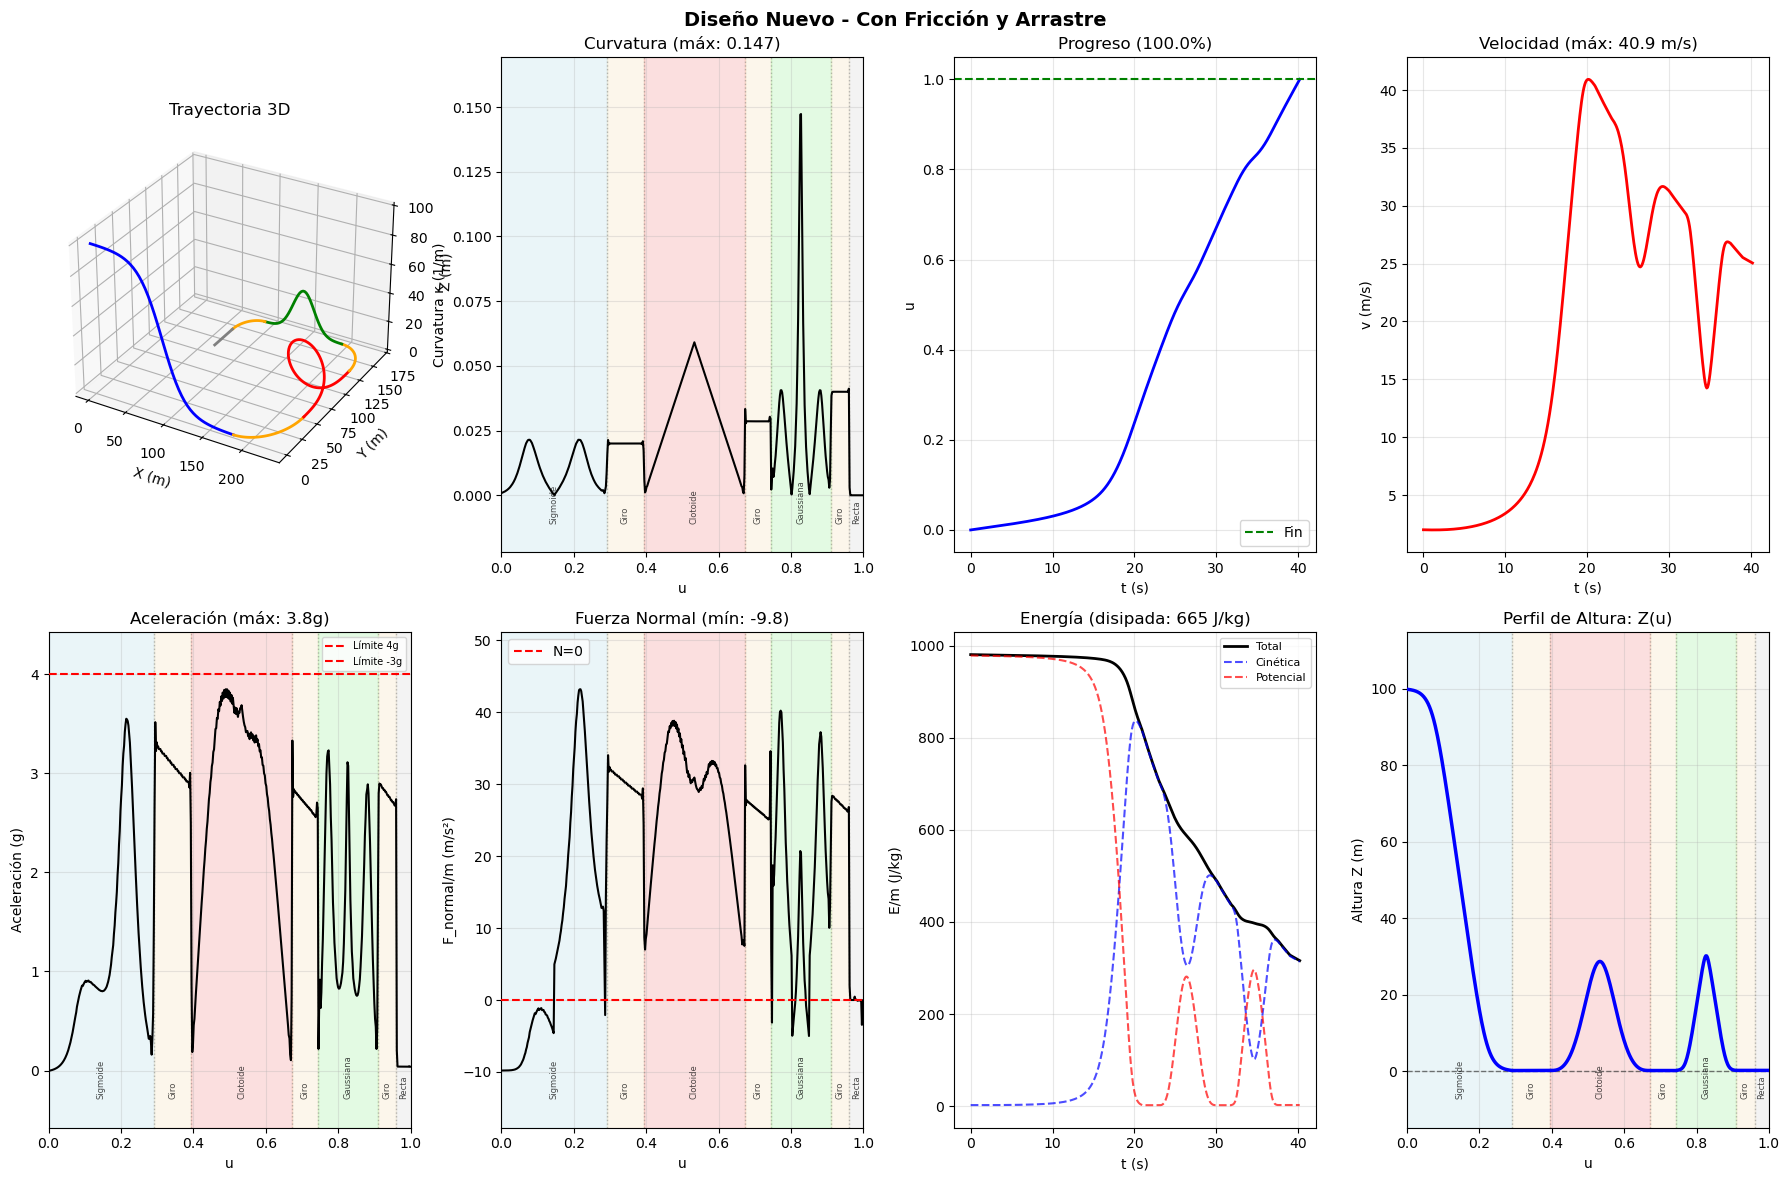

In [5]:
mr = MontañaRusa3D("Diseño Nuevo")
mr.agregar(Sigmoide3D(A=100, m=0.07, u_min=-90, u_max=90))
mr.agregar(GiroCircular3D(R=50, angulo=np.pi/2))
mr.agregar(Clotoide3D(A=60, alpha=np.arctan(np.sqrt(8/np.pi))))
mr.agregar(GiroCircular3D(R=35, angulo=np.pi/2))
mr.agregar(Gaussiana3D(A=30, s=20, u_min=-52, u_max=52))
mr.agregar(GiroCircular3D(R=25, angulo=np.pi/2))
mr.agregar(Recta3D(longitud=30, pendiente=0))
mr.construir()
    
# Simular
params = ParametrosFisicos()
sim = Simulador3D(mr, params)
sim.simular(metodo='DOP853')
sim.visualizar()
plt.show()


MONTAÑA RUSA 3D - PASO 4
Estudio de intervalos válidos de parámetros

1. CONSTRUYENDO MONTAÑA RUSA 3D VIABLE...

2. ANÁLISIS PARAMÉTRICO...

VARIANDO: masa
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
----------------------------------------------------------------------

📈 Explorando valores CRECIENTES...
  ✓ masa=800.0000: u=100.0%, acel= 3.9g
  ✗ masa=866.6667: u=100.0%, acel= 4.0g (>4g)
  ✗ masa=933.3333: u=100.0%, acel= 4.1g (>4g)
  ✗ masa=1000.0000: u=100.0%, acel= 4.2g (>4g)
  ✗ masa=1066.6667: u=100.0%, acel= 4.3g (>4g)
  ✗ masa=1133.3333: u=100.0%, acel= 4.6g (>4g)
  ✗ masa=1200.0000: u=100.0%, acel= 4.8g (>4g)

📉 Explorando valores DECRECIENTES...
  ✓ masa=733.3333: u=100.0%, acel= 3.8g
  ✓ masa=666.6667: u=100.0%, acel= 3.6g
  ✓ masa=600.0000: u=100.0%, acel= 3.4g
  ✓ masa=533.3333: u=100.0%, acel= 3.4g
  ✗ masa=500.0000: u=82.4%, acel= 3.5g (NO completa)
  ✗ masa=466.6667: u=81.9%, acel= 3.4g (NO completa)
  ⚠ Límite inferior en masa=433.333

────────────────

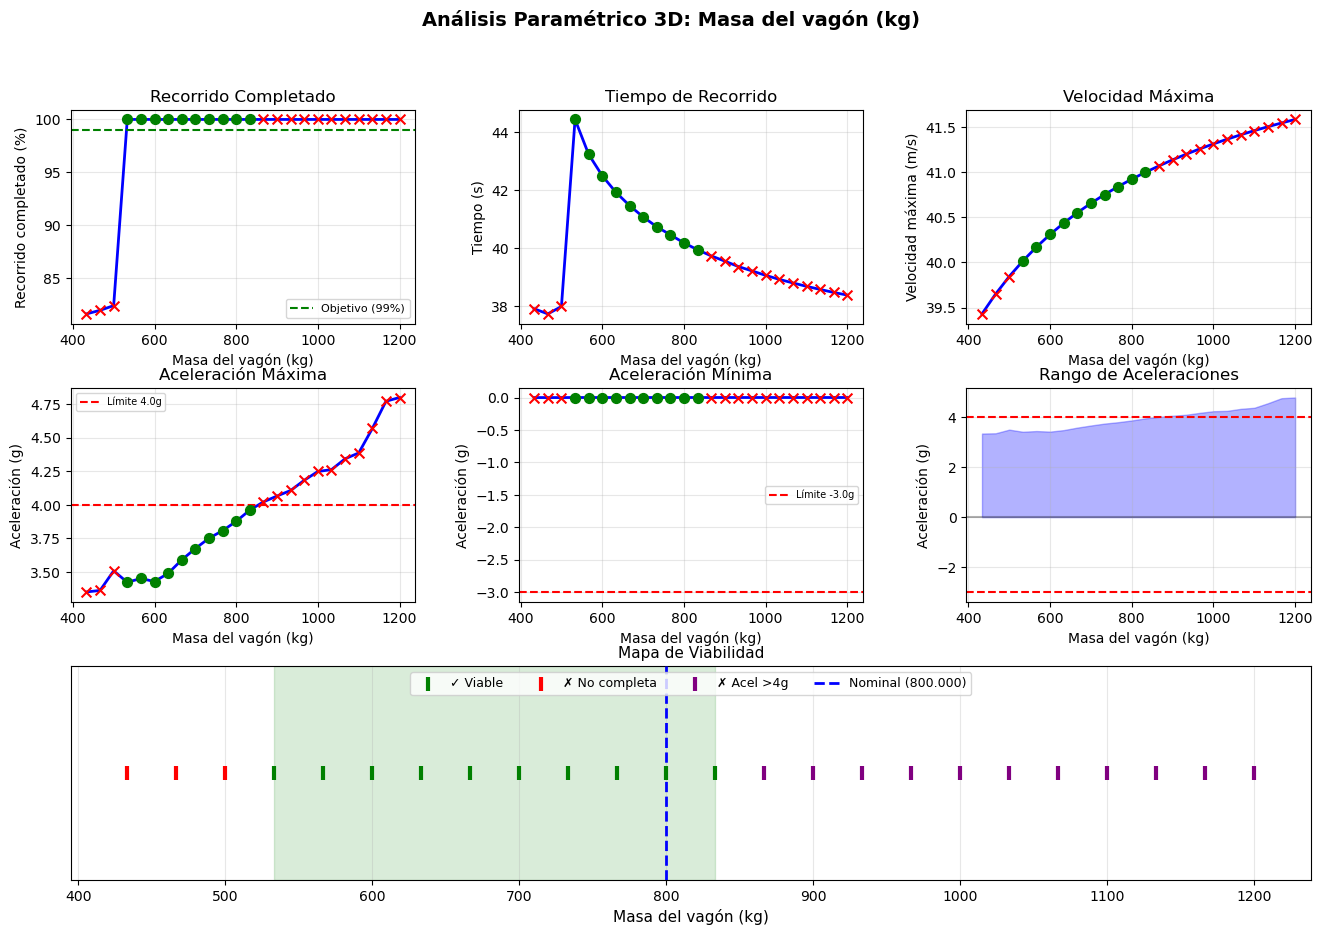


VARIANDO: mu
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
----------------------------------------------------------------------

📈 Explorando valores CRECIENTES...
  ✓ mu=  0.0153: u=100.0%, acel= 3.9g
  ✓ mu=  0.0214: u=100.0%, acel= 3.6g
  ✓ mu=  0.0275: u=100.0%, acel= 3.4g
  ✗ mu=  0.0296: u=82.4%, acel= 3.5g (NO completa)
  ✗ mu=  0.0337: u=81.8%, acel= 3.4g (NO completa)
  ⚠ Límite superior en mu=0.034

📉 Explorando valores DECRECIENTES...
  ✓ mu=  0.0133: u=100.0%, acel= 4.0g
  ✗ mu=  0.0112: u=100.0%, acel= 4.1g (>4g)
  ✗ mu=  0.0092: u=100.0%, acel= 4.2g (>4g)
  ✗ mu=  0.0071: u=100.0%, acel= 4.7g (>4g)
  ✗ mu=  0.0051: u=100.0%, acel= 5.2g (>4g)
  ✗ mu=  0.0030: u=100.0%, acel= 5.8g (>4g)
  ✗ mu=  0.0010: u=100.0%, acel= 6.5g (>4g)

──────────────────────────────────────────────────────────────────────
→ INTERVALO VIABLE: mu ∈ [0.013, 0.028]
  Valor nominal: 0.015
  Configuraciones viables: 8/17

Figura guardada: mr3d_paso4_mu.png


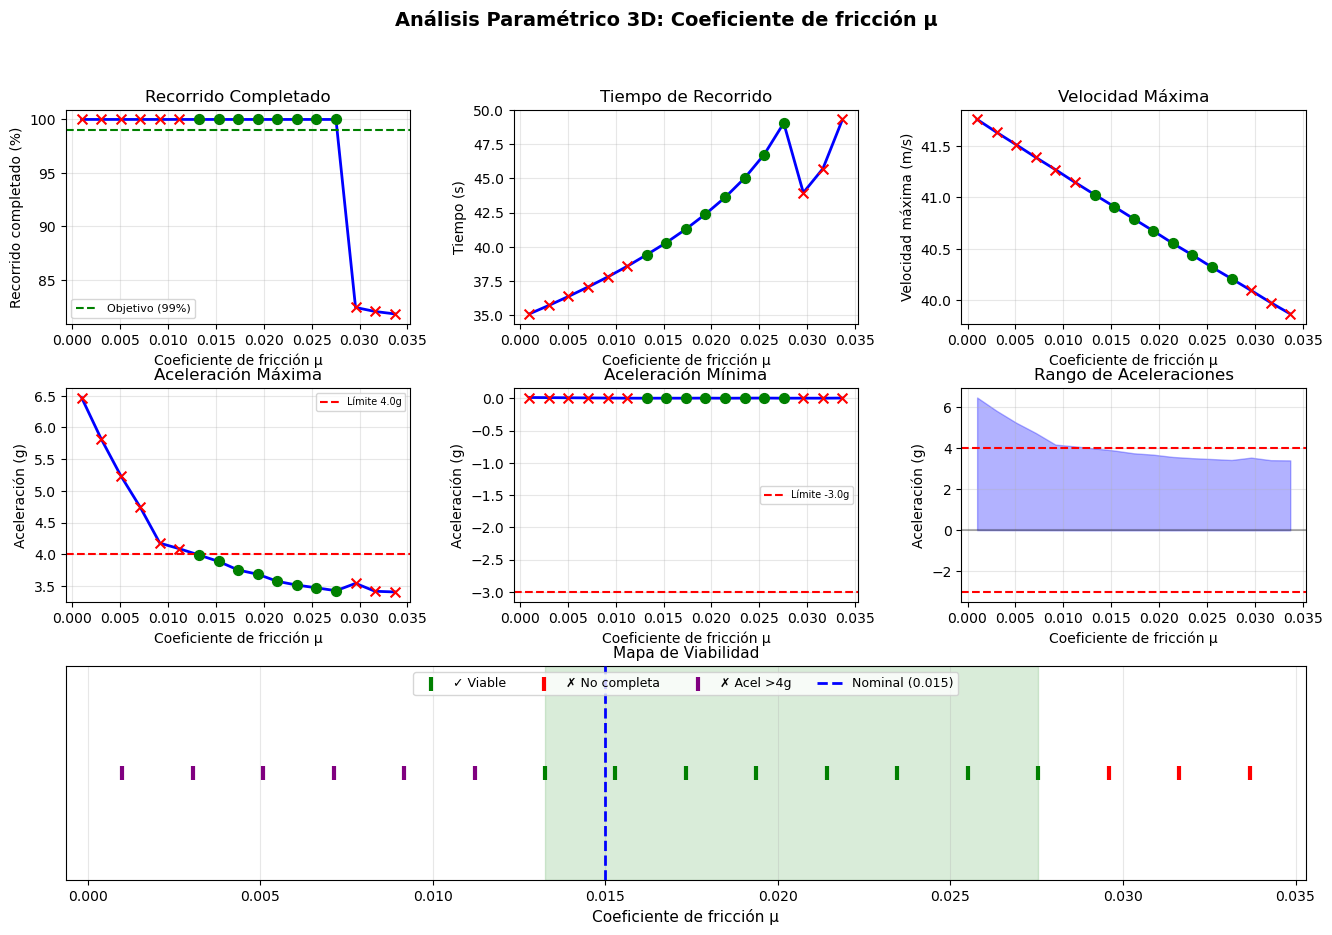


VARIANDO: ca
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
----------------------------------------------------------------------

📈 Explorando valores CRECIENTES...
  ✓ ca=  0.4125: u=100.0%, acel= 3.8g
  ✓ ca=  0.5938: u=100.0%, acel= 3.4g
  ✗ ca=  0.6542: u=82.2%, acel= 3.4g (NO completa)
  ✗ ca=  0.7750: u=81.4%, acel= 3.3g (NO completa)
  ⚠ Límite superior en ca=0.775

📉 Explorando valores DECRECIENTES...
  ✗ ca=  0.3521: u=100.0%, acel= 4.1g (>4g)
  ✗ ca=  0.2917: u=100.0%, acel= 4.4g (>4g)
  ✗ ca=  0.2313: u=100.0%, acel= 5.5g (>4g)
  ✗ ca=  0.1708: u=100.0%, acel= 6.6g (>4g)
  ✗ ca=  0.1104: u=100.0%, acel= 8.0g (>4g)
  ✗ ca=  0.0500: u=100.0%, acel= 9.4g (>4g)

──────────────────────────────────────────────────────────────────────
→ INTERVALO VIABLE: ca ∈ [0.412, 0.594]
  Valor nominal: 0.400
  Configuraciones viables: 4/13

Figura guardada: mr3d_paso4_ca.png


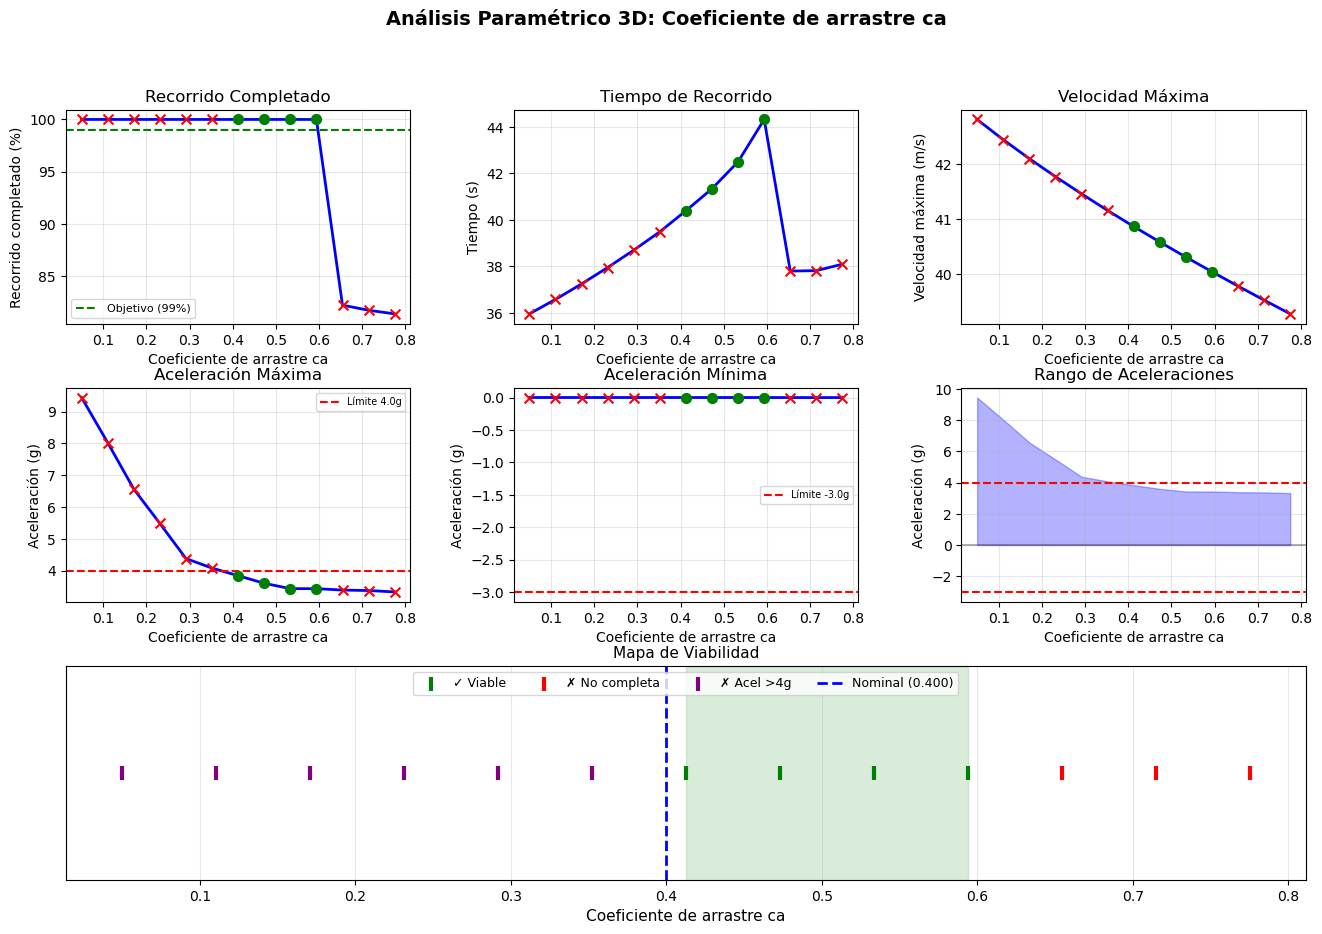


VARIANDO: Sf
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
----------------------------------------------------------------------

📈 Explorando valores CRECIENTES...
  ✓ Sf=  2.0000: u=100.0%, acel= 3.9g
  ✓ Sf=  2.5625: u=100.0%, acel= 3.5g
  ✓ Sf=  3.1250: u=100.0%, acel= 3.4g
  ✗ Sf=  3.3125: u=82.1%, acel= 3.4g (NO completa)
  ✗ Sf=  3.6875: u=81.6%, acel= 3.4g (NO completa)
  ⚠ Límite superior en Sf=3.688

📉 Explorando valores DECRECIENTES...
  ✗ Sf=  1.8125: u=100.0%, acel= 4.0g (>4g)
  ✗ Sf=  1.6250: u=100.0%, acel= 4.2g (>4g)
  ✗ Sf=  1.4375: u=100.0%, acel= 4.6g (>4g)
  ✗ Sf=  1.2500: u=100.0%, acel= 5.2g (>4g)
  ✗ Sf=  1.0625: u=100.0%, acel= 5.8g (>4g)
  ✗ Sf=  0.8750: u=100.0%, acel= 6.5g (>4g)
  ✗ Sf=  0.6875: u=100.0%, acel= 7.3g (>4g)
  ✗ Sf=  0.5000: u=100.0%, acel= 8.1g (>4g)

──────────────────────────────────────────────────────────────────────
→ INTERVALO VIABLE: Sf ∈ [2.000, 3.125]
  Valor nominal: 2.000
  Configuraciones viables: 7/18

Figura guarda

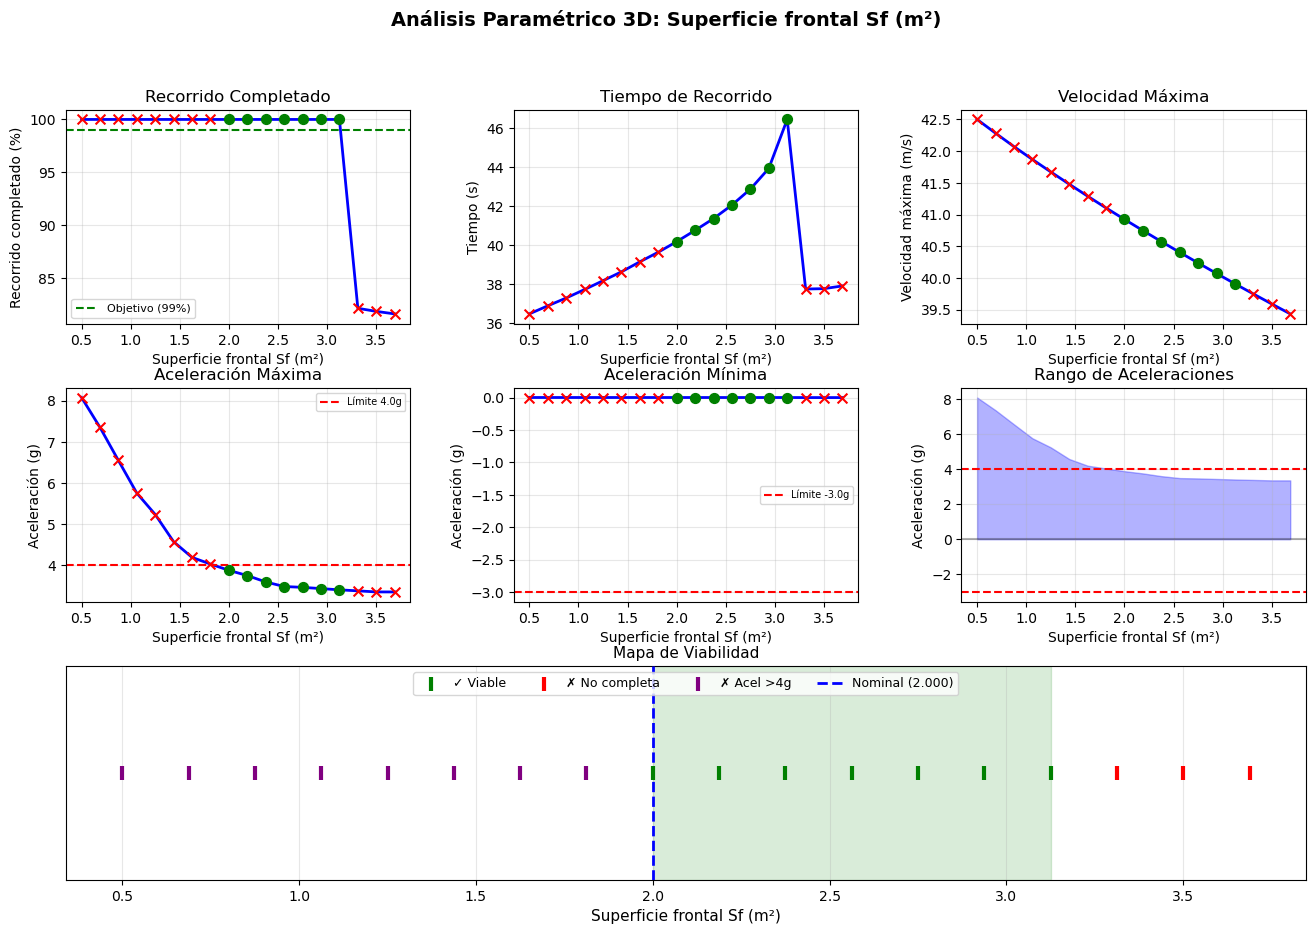


VARIANDO: v0
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
----------------------------------------------------------------------

📈 Explorando valores CRECIENTES...
  ✓ v0=  1.9386: u=100.0%, acel= 3.9g
  ✓ v0=  3.0407: u=100.0%, acel= 3.9g
  ✓ v0=  4.1428: u=100.0%, acel= 3.9g
  ✓ v0=  5.2448: u=100.0%, acel= 3.9g
  ✓ v0=  6.3469: u=100.0%, acel= 4.0g
  ✗ v0=  7.4490: u=100.0%, acel= 4.0g (>4g)

📉 Explorando valores DECRECIENTES...
  ✓ v0=  1.6631: u=100.0%, acel= 3.9g
  ✓ v0=  1.3876: u=100.0%, acel= 3.9g
  ✓ v0=  1.1121: u=100.0%, acel= 3.9g
  ✓ v0=  0.8366: u=100.0%, acel= 3.9g
  ✗ v0=  0.5610: u= 0.7%, acel= 0.0g (ESTANCADO)
  ⚠ Estancamiento en v0=0.561

──────────────────────────────────────────────────────────────────────
→ INTERVALO VIABLE: v0 ∈ [0.837, 7.173]
  Valor nominal: 2.000
  Configuraciones viables: 24/28

Figura guardada: mr3d_paso4_v0.png


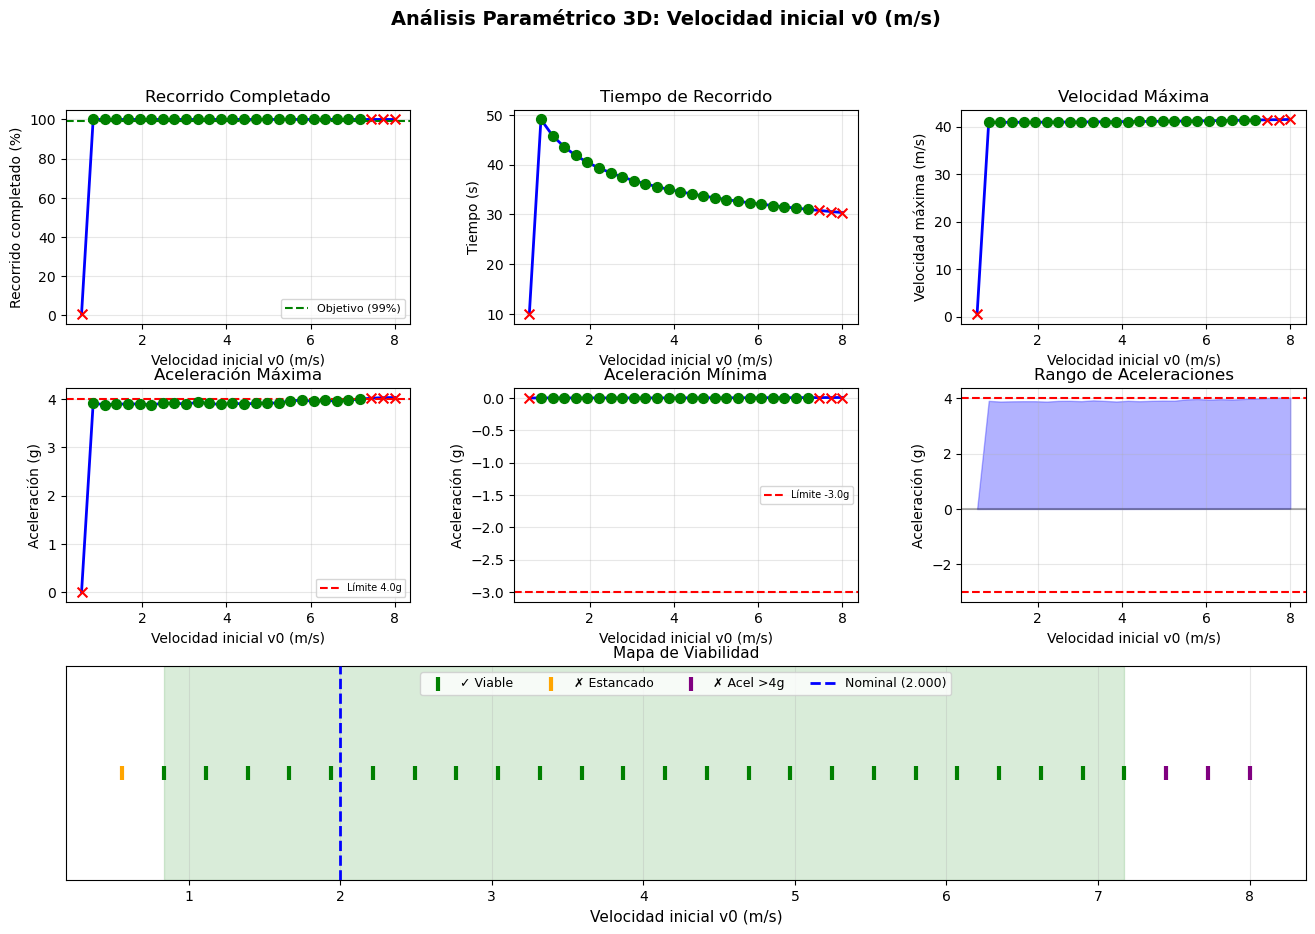


RESUMEN DE INTERVALOS VÁLIDOS - MONTAÑA RUSA 3D
Parámetro            Valor Base      Intervalo Viable              
----------------------------------------------------------------------
Masa (kg)            800.0000        [533.3333, 833.3333]          
Coef. fricción μ     0.0150          [0.0133, 0.0275]              
Coef. arrastre ca    0.4000          [0.4125, 0.5938]              
Superficie Sf (m²)   2.0000          [2.0000, 3.1250]              
Velocidad v0 (m/s)   2.0000          [0.8366, 7.1734]              

PASO 4 COMPLETADO

Interpretación de resultados 3D:

1. MASA (m): Mayor masa → mayor inercia, menos afectada por fricción/arrastre
   pero necesita más energía para subir colinas y loops.

2. FRICCIÓN (μ): Pérdidas ∝ μ·N. Los giros 3D añaden fuerza normal adicional.

3. ARRASTRE (ca): Pérdidas ∝ ca·v². Muy importante en el descenso inicial.

4. SUPERFICIE FRONTAL (Sf): Similar a ca, aumenta resistencia aerodinámica.

5. VELOCIDAD INICIAL (v0): Con un descenso de ~100

In [6]:
# -*- coding: utf-8 -*-
"""
Montaña Rusa 3D - Paso 4: Estudio de intervalos válidos de parámetros

Análisis de sensibilidad para:
- Masa del vagón (m)
- Coeficiente de fricción (μ)
- Coeficiente de arrastre (ca)
- Superficie frontal (Sf)
- Velocidad inicial (v0)

Criterios de viabilidad (UNE-EN 13814-1 Anexo I):
- Completa el recorrido (u_final ≥ 0.99)
- Aceleración máxima < 4g sostenida
- Aceleración negativa > -3g
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as scip
import scipy.integrate as scin
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

import pkgcurvas as curvas
import pkgmrusa as mrusa

# =============================================================================
# SEGMENTOS 3D (del paso 3)
# =============================================================================

class Segmento3D:
    def __init__(self, nombre, color='blue'):
        self.nombre = nombre
        self.color = color
        self.x, self.y, self.z = None, None, None
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        raise NotImplementedError
    
    def get_punto_final(self):
        return self.x[-1], self.y[-1], self.z[-1]

class Sigmoide3D(Segmento3D):
    def __init__(self, A=100, m=0.5, u_min=-20, u_max=20, color='blue'):
        super().__init__(f'Sigmoide(A={A}, m={m})', color)
        self.A, self.m = A, m
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        _, z_sig = curvas.sigmoide(u, A=self.A, s=self.m)
        distancia = u - self.u_min
        self.x = x0 + distancia * np.cos(direccion_entrada)
        self.y = y0 + distancia * np.sin(direccion_entrada)
        self.z = z0 + z_sig
        return self.x, self.y, self.z, direccion_entrada

class GiroCircular3D(Segmento3D):
    def __init__(self, R=20, angulo=np.pi/2, sentido='izquierda', variacion_z=0, color='orange'):
        super().__init__(f'Giro(R={R}, α={np.degrees(angulo):.0f}°)', color)
        self.R, self.angulo = R, angulo
        self.sentido = sentido
        self.variacion_z = variacion_z
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        signo = 1 if self.sentido == 'izquierda' else -1
        angulo_centro = direccion_entrada + signo * np.pi/2
        cx = x0 + self.R * np.cos(angulo_centro)
        cy = y0 + self.R * np.sin(angulo_centro)
        theta_inicial = direccion_entrada - signo * np.pi/2
        theta = np.linspace(0, signo * self.angulo, n_puntos)
        self.x = cx + self.R * np.cos(theta_inicial + theta)
        self.y = cy + self.R * np.sin(theta_inicial + theta)
        self.z = z0 + self.variacion_z * (theta / (signo * self.angulo))
        direccion_salida = direccion_entrada + signo * self.angulo
        return self.x, self.y, self.z, direccion_salida

class Clotoide3D(Segmento3D):
    def __init__(self, A=35, alpha=0, color='red'):
        super().__init__(f'Clotoide(A={A}, α={np.degrees(alpha):.1f}°)', color)
        self.A, self.alpha = A, alpha
        self.u_max = np.sqrt(np.pi)
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=80):
        u = np.linspace(0, self.u_max, n_puntos)
        x_local, z_local = curvas.clotoide(u, A=self.A, p0=0)
        x_full = np.concatenate([x_local, 2*x_local[-1] - x_local[::-1][1:]])
        z_full = np.concatenate([z_local, z_local[::-1][1:]])
        y_full = z_full * np.sin(self.alpha)
        z_full = z_full * np.cos(self.alpha)
        cos_dir, sin_dir = np.cos(direccion_entrada), np.sin(direccion_entrada)
        x_rot = x_full * cos_dir - y_full * sin_dir
        y_rot = x_full * sin_dir + y_full * cos_dir
        self.x = x0 + x_rot
        self.y = y0 + y_rot
        self.z = z0 + z_full
        return self.x, self.y, self.z, direccion_entrada

class Gaussiana3D(Segmento3D):
    def __init__(self, A=30, s=20, u_min=-52, u_max=52, color='green'):
        super().__init__(f'Gaussiana(A={A}, s={s})', color)
        self.A, self.s = A, s
        self.u_min, self.u_max = u_min, u_max
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        _, z_gauss = curvas.gausiana(u, A=self.A, s=self.s)
        distancia = u - self.u_min
        self.x = x0 + distancia * np.cos(direccion_entrada)
        self.y = y0 + distancia * np.sin(direccion_entrada)
        self.z = z0 + z_gauss
        return self.x, self.y, self.z, direccion_entrada

class Recta3D(Segmento3D):
    def __init__(self, longitud=30, pendiente=0, color='gray'):
        super().__init__(f'Recta(L={longitud}, m={pendiente})', color)
        self.longitud, self.pendiente = longitud, pendiente
    
    def generar(self, x0, y0, z0, direccion_entrada=0, n_puntos=20):
        u = np.linspace(0, self.longitud, n_puntos)
        self.x = x0 + u * np.cos(direccion_entrada)
        self.y = y0 + u * np.sin(direccion_entrada)
        self.z = z0 + self.pendiente * u
        return self.x, self.y, self.z, direccion_entrada

# =============================================================================
# MONTAÑA RUSA 3D
# =============================================================================

class MontañaRusa3D:
    def __init__(self, nombre="Montaña Rusa 3D"):
        self.nombre = nombre
        self.segmentos = []
        self.x_total, self.y_total, self.z_total = None, None, None
        self.bspline = None
        self.limites_u = None
    
    def agregar(self, segmento):
        self.segmentos.append(segmento)
        return self
    
    def construir(self, x0=0, y0=0, z0=0, dir0=0, n_puntos=50, verbose=False):
        x_act, y_act, z_act, dir_act = x0, y0, z0, dir0
        arrays_x, arrays_y, arrays_z = [], [], []
        
        for i, seg in enumerate(self.segmentos):
            x, y, z, dir_salida = seg.generar(x_act, y_act, z_act, dir_act, n_puntos)
            arrays_x.append(x if i == 0 else x[1:])
            arrays_y.append(y if i == 0 else y[1:])
            arrays_z.append(z if i == 0 else z[1:])
            x_act, y_act, z_act = seg.get_punto_final()
            dir_act = dir_salida
        
        self.x_total = np.concatenate(arrays_x)
        self.y_total = np.concatenate(arrays_y)
        self.z_total = np.concatenate(arrays_z)
        
        puntos_3d = np.array([self.x_total, self.y_total, self.z_total])
        tck, _ = scip.splprep(puntos_3d, s=0, k=3)
        t, c, k = tck
        self.bspline = scip.BSpline(t, np.array(c).T, k)
        
        self._calcular_limites_u()
        return self
    
    def _calcular_limites_u(self):
        longitudes = []
        for seg in self.segmentos:
            dx = np.diff(seg.x)
            dy = np.diff(seg.y)
            dz = np.diff(seg.z)
            long_seg = np.sum(np.sqrt(dx**2 + dy**2 + dz**2))
            longitudes.append(long_seg)
        
        long_total = sum(longitudes)
        self.limites_u = [0.0]
        u_acum = 0
        for long in longitudes[:-1]:
            u_acum += long / long_total
            self.limites_u.append(u_acum)
        self.limites_u.append(1.0)

# =============================================================================
# PARÁMETROS FÍSICOS
# =============================================================================

class ParametrosFisicos:
    def __init__(self, masa=800, v0=2.0, mu=0.015, ca=0.4, 
                 Sf=2.0, rho_a=1.225, grav=9.81):
        self.masa = masa
        self.v0 = v0
        self.mu = mu
        self.ca = ca
        self.Sf = Sf
        self.rho_a = rho_a
        self.grav = grav
        self.cv = ca * Sf * rho_a / (2 * masa)

# =============================================================================
# ANALIZADOR PARAMÉTRICO 3D
# =============================================================================

class AnalizadorParametrico3D:
    """
    Análisis de sensibilidad para montaña rusa 3D.
    Varía un parámetro manteniendo los demás constantes.
    """
    
    # Límites UNE-EN 13814-1 Anexo I
    ACEL_MAX_POSITIVA = 4.0   # g
    ACEL_MAX_NEGATIVA = -3.0  # g
    ACEL_SOSTENIDA = 4.0      # g
    TIEMPO_SOSTENIDA = 4.0    # s
    
    def __init__(self, montaña_rusa, params_base):
        self.mr = montaña_rusa
        self.params_base = params_base
        self.bspline = montaña_rusa.bspline
        self.derivadas = mrusa.trayec_der(self.bspline)
        self.resultados = {}
    
    def simular_con_params(self, params, verbose=False):
        """Simula y retorna métricas de viabilidad."""
        try:
            sol = scin.solve_ivp(
                mrusa.edofun_mr,
                [0, 300],
                [0.0, params.v0],
                method='DOP853',
                args=[self.derivadas, params.mu, params.cv, params.grav],
                events=[mrusa.finalVia, mrusa.paradaVagon],
                dense_output=True,
                max_step=0.1
            )
            
            if not sol.success:
                return None
            
            u_final = sol.y[0][-1]
            v = sol.y[1]
            t = sol.t
            
            # Verificar estancamiento
            if len(t) > 10:
                idx_10s = np.argmin(np.abs(t - 10))
                u_10s = sol.y[0][min(idx_10s, len(sol.y[0])-1)]
                if u_10s < 0.01:
                    return {
                        'completa': False, 'u_final': u_10s, 't_final': 10.0,
                        'v_max': params.v0, 'v_min': 0.0,
                        'acel_max_g': 0.0, 'acel_min_g': 0.0,
                        'acel_excede_4g': False, 'acel_excede_neg3g': False,
                        'acel_sostenida_violada': False, 'viable': False,
                        'estancado': True
                    }
            
            # Calcular aceleraciones
            u_eval = np.linspace(0, min(u_final, 1.0), 200)
            acel_total = []
            
            for u_i in u_eval:
                idx = np.argmin(np.abs(sol.y[0] - u_i))
                v_i = v[idx]
                try:
                    fN, base, ctes = mrusa.fuerzaNormal(u_i, v_i, self.derivadas, params.grav)
                    acel = mrusa.aceleracion(v_i, base, params.mu, params.cv, 
                                            fN, ctes[1], params.grav)
                    acel_total.append(acel[0])
                except:
                    acel_total.append(0)
            
            acel_total = np.array(acel_total)
            acel_g = acel_total / params.grav
            
            # Verificar aceleración sostenida
            violacion_sostenida = False
            if len(t) > 10:
                dt = np.diff(t)
                for i in range(len(acel_g) - 10):
                    if np.all(np.abs(acel_g[i:i+10]) > self.ACEL_SOSTENIDA):
                        tiempo_acum = np.sum(dt[i:i+10]) if i < len(dt)-10 else 0
                        if tiempo_acum > self.TIEMPO_SOSTENIDA:
                            violacion_sostenida = True
                            break
            
            return {
                'completa': u_final >= 0.99,
                'u_final': u_final,
                't_final': t[-1],
                'v_max': v.max(),
                'v_min': v.min(),
                'acel_max_g': acel_g.max(),
                'acel_min_g': acel_g.min(),
                'acel_excede_4g': acel_g.max() > self.ACEL_MAX_POSITIVA,
                'acel_excede_neg3g': acel_g.min() < self.ACEL_MAX_NEGATIVA,
                'acel_sostenida_violada': violacion_sostenida,
                'viable': (u_final >= 0.99 and 
                          acel_g.max() <= self.ACEL_MAX_POSITIVA and
                          acel_g.min() >= self.ACEL_MAX_NEGATIVA and
                          not violacion_sostenida),
                'sol': sol,
                'estancado': False
            }
            
        except Exception as e:
            if verbose:
                print(f"Error: {e}")
            return None
    
    def variar_parametro(self, nombre_param, valores, verbose=True):
        """Varía un parámetro desde el nominal hacia ambas direcciones."""
        if verbose:
            print(f"\n{'='*70}")
            print(f"VARIANDO: {nombre_param}")
            print(f"{'='*70}")
            print(f"Valores base: m={self.params_base.masa}kg, "
                  f"μ={self.params_base.mu}, ca={self.params_base.ca}, "
                  f"Sf={self.params_base.Sf}m², v0={self.params_base.v0}m/s")
            print(f"{'-'*70}")
        
        # Valor nominal
        val_nominal = getattr(self.params_base, nombre_param)
        idx_nominal = np.argmin(np.abs(valores - val_nominal))
        
        resultados = []
        
        # FASE 1: Hacia valores crecientes
        if verbose:
            print("\n📈 Explorando valores CRECIENTES...")
        
        no_completa = 0
        for i in range(idx_nominal, len(valores)):
            val = valores[i]
            params = self._crear_params_modificados(nombre_param, val)
            metricas = self.simular_con_params(params)
            
            if metricas:
                metricas['valor_param'] = val
                resultados.append(metricas)
                
                if not metricas['completa']:
                    no_completa += 1
                else:
                    no_completa = 0
                
                if verbose and (i == idx_nominal or no_completa == 1 or 
                               (i - idx_nominal) % max(1, (len(valores)-idx_nominal)//5) == 0):
                    self._imprimir_resultado(nombre_param, val, metricas)
                
                if no_completa >= 3:
                    if verbose:
                        print(f"  ⚠ Límite superior en {nombre_param}={val:.3f}")
                    break
        
        # FASE 2: Hacia valores decrecientes
        if verbose:
            print("\n📉 Explorando valores DECRECIENTES...")
        
        no_completa = 0
        for i in range(idx_nominal - 1, -1, -1):
            val = valores[i]
            params = self._crear_params_modificados(nombre_param, val)
            metricas = self.simular_con_params(params)
            
            if metricas:
                metricas['valor_param'] = val
                resultados.append(metricas)
                
                if metricas.get('estancado', False):
                    if verbose:
                        self._imprimir_resultado(nombre_param, val, metricas)
                        print(f"  ⚠ Estancamiento en {nombre_param}={val:.3f}")
                    break
                
                if not metricas['completa']:
                    no_completa += 1
                else:
                    no_completa = 0
                
                if verbose and (no_completa == 1 or 
                               (idx_nominal - i) % max(1, idx_nominal//5) == 0):
                    self._imprimir_resultado(nombre_param, val, metricas)
                
                if no_completa >= 3:
                    if verbose:
                        print(f"  ⚠ Límite inferior en {nombre_param}={val:.3f}")
                    break
        
        # Ordenar y guardar
        resultados.sort(key=lambda x: x['valor_param'])
        self.resultados[nombre_param] = resultados
        
        # Determinar intervalo viable
        viables = [r for r in resultados if r['viable']]
        if viables:
            vals_viables = [r['valor_param'] for r in viables]
            intervalo = (min(vals_viables), max(vals_viables))
            if verbose:
                print(f"\n{'─'*70}")
                print(f"→ INTERVALO VIABLE: {nombre_param} ∈ [{intervalo[0]:.3f}, {intervalo[1]:.3f}]")
                print(f"  Valor nominal: {val_nominal:.3f}")
                print(f"  Configuraciones viables: {len(viables)}/{len(resultados)}")
        else:
            intervalo = None
            if verbose:
                print(f"\n→ ⚠ NO HAY VALORES VIABLES")
        
        return resultados, intervalo
    
    def _crear_params_modificados(self, nombre_param, val):
        """Crea ParametrosFisicos con un parámetro modificado."""
        params = ParametrosFisicos(
            masa=self.params_base.masa,
            v0=self.params_base.v0,
            mu=self.params_base.mu,
            ca=self.params_base.ca,
            Sf=self.params_base.Sf
        )
        
        setattr(params, nombre_param, val)
        
        # Recalcular cv si es necesario
        if nombre_param in ['masa', 'ca', 'Sf']:
            params.cv = params.ca * params.Sf * params.rho_a / (2 * params.masa)
        
        return params
    
    def _imprimir_resultado(self, nombre_param, val, metricas):
        """Imprime resultado de simulación."""
        simbolo = '✓' if metricas['viable'] else '✗'
        razon = ""
        
        if metricas.get('estancado'):
            razon = " (ESTANCADO)"
        elif not metricas['completa']:
            razon = " (NO completa)"
        elif metricas['acel_excede_4g']:
            razon = " (>4g)"
        elif metricas['acel_excede_neg3g']:
            razon = " (<-3g)"
        
        print(f"  {simbolo} {nombre_param}={val:8.4f}: "
              f"u={metricas['u_final']:5.1%}, "
              f"acel={metricas['acel_max_g']:4.1f}g{razon}")
    
    def visualizar_parametro(self, nombre_param, guardar=True):
        """Genera gráficos de análisis para un parámetro."""
        if nombre_param not in self.resultados:
            print(f"No hay resultados para {nombre_param}")
            return
        
        resultados = self.resultados[nombre_param]
        if not resultados:
            return
        
        # Extraer datos
        vals = np.array([r['valor_param'] for r in resultados])
        u_final = np.array([r['u_final'] for r in resultados])
        t_final = np.array([r['t_final'] for r in resultados])
        v_max = np.array([r['v_max'] for r in resultados])
        acel_max_g = np.array([r['acel_max_g'] for r in resultados])
        acel_min_g = np.array([r['acel_min_g'] for r in resultados])
        viable = np.array([r['viable'] for r in resultados])
        
        fig = plt.figure(figsize=(16, 10))
        gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
        
        nombres = {
            'masa': 'Masa del vagón (kg)',
            'mu': 'Coeficiente de fricción μ',
            'ca': 'Coeficiente de arrastre ca',
            'Sf': 'Superficie frontal Sf (m²)',
            'v0': 'Velocidad inicial v0 (m/s)'
        }
        nombre_eje = nombres.get(nombre_param, nombre_param)
        
        # 1. Recorrido completado
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(vals, u_final * 100, 'b-', lw=2)
        ax1.axhline(99, color='g', ls='--', label='Objetivo (99%)')
        ax1.scatter(vals[viable], (u_final * 100)[viable], c='g', s=50, marker='o', zorder=5)
        ax1.scatter(vals[~viable], (u_final * 100)[~viable], c='r', s=50, marker='x', zorder=5)
        ax1.set_xlabel(nombre_eje)
        ax1.set_ylabel('Recorrido completado (%)')
        ax1.set_title('Recorrido Completado')
        ax1.legend(fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # 2. Tiempo de recorrido
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(vals, t_final, 'b-', lw=2)
        ax2.scatter(vals[viable], t_final[viable], c='g', s=50, marker='o', zorder=5)
        ax2.scatter(vals[~viable], t_final[~viable], c='r', s=50, marker='x', zorder=5)
        ax2.set_xlabel(nombre_eje)
        ax2.set_ylabel('Tiempo (s)')
        ax2.set_title('Tiempo de Recorrido')
        ax2.grid(True, alpha=0.3)
        
        # 3. Velocidad máxima
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.plot(vals, v_max, 'b-', lw=2)
        ax3.scatter(vals[viable], v_max[viable], c='g', s=50, marker='o', zorder=5)
        ax3.scatter(vals[~viable], v_max[~viable], c='r', s=50, marker='x', zorder=5)
        ax3.set_xlabel(nombre_eje)
        ax3.set_ylabel('Velocidad máxima (m/s)')
        ax3.set_title('Velocidad Máxima')
        ax3.grid(True, alpha=0.3)
        
        # 4. Aceleración máxima
        ax4 = fig.add_subplot(gs[1, 0])
        ax4.plot(vals, acel_max_g, 'b-', lw=2)
        ax4.axhline(self.ACEL_MAX_POSITIVA, color='r', ls='--', label=f'Límite {self.ACEL_MAX_POSITIVA}g')
        ax4.scatter(vals[viable], acel_max_g[viable], c='g', s=50, marker='o', zorder=5)
        ax4.scatter(vals[~viable], acel_max_g[~viable], c='r', s=50, marker='x', zorder=5)
        ax4.set_xlabel(nombre_eje)
        ax4.set_ylabel('Aceleración (g)')
        ax4.set_title('Aceleración Máxima')
        ax4.legend(fontsize=7)
        ax4.grid(True, alpha=0.3)
        
        # 5. Aceleración mínima
        ax5 = fig.add_subplot(gs[1, 1])
        ax5.plot(vals, acel_min_g, 'b-', lw=2)
        ax5.axhline(self.ACEL_MAX_NEGATIVA, color='r', ls='--', label=f'Límite {self.ACEL_MAX_NEGATIVA}g')
        ax5.scatter(vals[viable], acel_min_g[viable], c='g', s=50, marker='o', zorder=5)
        ax5.scatter(vals[~viable], acel_min_g[~viable], c='r', s=50, marker='x', zorder=5)
        ax5.set_xlabel(nombre_eje)
        ax5.set_ylabel('Aceleración (g)')
        ax5.set_title('Aceleración Mínima')
        ax5.legend(fontsize=7)
        ax5.grid(True, alpha=0.3)
        
        # 6. Rango de aceleraciones
        ax6 = fig.add_subplot(gs[1, 2])
        ax6.fill_between(vals, acel_min_g, acel_max_g, alpha=0.3, color='blue')
        ax6.axhline(self.ACEL_MAX_POSITIVA, color='r', ls='--')
        ax6.axhline(self.ACEL_MAX_NEGATIVA, color='r', ls='--')
        ax6.axhline(0, color='k', ls='-', alpha=0.3)
        ax6.set_xlabel(nombre_eje)
        ax6.set_ylabel('Aceleración (g)')
        ax6.set_title('Rango de Aceleraciones')
        ax6.grid(True, alpha=0.3)
        
        # 7. Mapa de viabilidad
        ax7 = fig.add_subplot(gs[2, :])
        
        estancado_mask = np.array([r.get('estancado', False) for r in resultados])
        no_completa_mask = np.array([not r['completa'] and not r.get('estancado', False) for r in resultados])
        acel_alta_mask = np.array([r['completa'] and r['acel_excede_4g'] for r in resultados])
        
        if any(viable):
            ax7.scatter(vals[viable], np.ones(sum(viable)), c='green', s=100, 
                       marker='|', linewidths=3, label='✓ Viable', zorder=5)
        if any(estancado_mask):
            ax7.scatter(vals[estancado_mask], np.ones(sum(estancado_mask)), c='orange', 
                       s=100, marker='|', linewidths=3, label='✗ Estancado', zorder=4)
        if any(no_completa_mask):
            ax7.scatter(vals[no_completa_mask], np.ones(sum(no_completa_mask)), c='red', 
                       s=100, marker='|', linewidths=3, label='✗ No completa', zorder=4)
        if any(acel_alta_mask):
            ax7.scatter(vals[acel_alta_mask], np.ones(sum(acel_alta_mask)), c='purple', 
                       s=100, marker='|', linewidths=3, label='✗ Acel >4g', zorder=4)
        
        if any(viable):
            vals_viables = vals[viable]
            ax7.axvspan(vals_viables.min(), vals_viables.max(), alpha=0.15, color='green', zorder=1)
        
        val_base = getattr(self.params_base, nombre_param)
        ax7.axvline(val_base, color='blue', ls='--', lw=2, label=f'Nominal ({val_base:.3f})', zorder=3)
        
        ax7.set_xlabel(nombre_eje, fontsize=11)
        ax7.set_yticks([])
        ax7.set_title('Mapa de Viabilidad', fontsize=11)
        ax7.legend(fontsize=9, loc='upper center', ncol=6)
        ax7.set_ylim(0.5, 1.5)
        ax7.grid(True, axis='x', alpha=0.3)
        
        plt.suptitle(f'Análisis Paramétrico 3D: {nombre_eje}', fontsize=14, fontweight='bold')
        
        if guardar:
            archivo = f'mr3d_paso4_{nombre_param}.png'
            plt.savefig(archivo, dpi=150, bbox_inches='tight')
            print(f"\nFigura guardada: {archivo}")
        
        plt.show()
        return fig
    
    def resumen_intervalos(self):
        """Genera tabla resumen."""
        print("\n" + "="*70)
        print("RESUMEN DE INTERVALOS VÁLIDOS - MONTAÑA RUSA 3D")
        print("="*70)
        print(f"{'Parámetro':<20} {'Valor Base':<15} {'Intervalo Viable':<30}")
        print("-"*70)
        
        nombres = {
            'masa': ('Masa (kg)', self.params_base.masa),
            'mu': ('Coef. fricción μ', self.params_base.mu),
            'ca': ('Coef. arrastre ca', self.params_base.ca),
            'Sf': ('Superficie Sf (m²)', self.params_base.Sf),
            'v0': ('Velocidad v0 (m/s)', self.params_base.v0)
        }
        
        for param, resultados in self.resultados.items():
            if param in nombres:
                nombre, val_base = nombres[param]
                viables = [r for r in resultados if r['viable']]
                
                if viables:
                    vals = [r['valor_param'] for r in viables]
                    intervalo = f"[{min(vals):.4f}, {max(vals):.4f}]"
                else:
                    intervalo = "Sin valores viables"
                
                print(f"{nombre:<20} {val_base:<15.4f} {intervalo:<30}")
        
        print("="*70)

# =============================================================================
# PROGRAMA PRINCIPAL
# =============================================================================

if __name__ == "__main__":
    print("="*70)
    print("MONTAÑA RUSA 3D - PASO 4")
    print("Estudio de intervalos válidos de parámetros")
    print("="*70)
    
    # 1. Construir montaña rusa viable (del paso 3)
    print("\n1. CONSTRUYENDO MONTAÑA RUSA 3D VIABLE...")
    mr = MontañaRusa3D("Diseño Nuevo 3D")
    mr.agregar(Sigmoide3D(A=100, m=0.07, u_min=-90, u_max=90))
    mr.agregar(GiroCircular3D(R=50, angulo=np.pi/2))
    mr.agregar(Clotoide3D(A=60, alpha=np.arctan(np.sqrt(8/np.pi))))
    mr.agregar(GiroCircular3D(R=35, angulo=np.pi/2))
    mr.agregar(Gaussiana3D(A=30, s=20, u_min=-52, u_max=52))
    mr.agregar(GiroCircular3D(R=25, angulo=np.pi/2))
    mr.agregar(Recta3D(longitud=30, pendiente=0))
    mr.construir(verbose=True)
    
    # Parámetros base
    params_base = ParametrosFisicos(
        masa=800, v0=2.0, mu=0.015, ca=0.4, Sf=2.0
    )
    
    # 2. Crear analizador
    analizador = AnalizadorParametrico3D(mr, params_base)
    
    # 3. Análisis de cada parámetro
    print("\n2. ANÁLISIS PARAMÉTRICO...")
    
    # Masa (kg): ±50%
    analizador.variar_parametro('masa', np.linspace(400, 1200, 25))
    analizador.visualizar_parametro('masa')
    
    # Coeficiente de fricción μ
    analizador.variar_parametro('mu', np.linspace(0.001, 0.05, 25))
    analizador.visualizar_parametro('mu')
    
    # Coeficiente de arrastre ca
    analizador.variar_parametro('ca', np.linspace(0.05, 1.5, 25))
    analizador.visualizar_parametro('ca')
    
    # Superficie frontal Sf (m²)
    analizador.variar_parametro('Sf', np.linspace(0.5, 5.0, 25))
    analizador.visualizar_parametro('Sf')
    
    # Velocidad inicial v0 (m/s)
    analizador.variar_parametro('v0', np.linspace(0.01, 8.0, 30))
    analizador.visualizar_parametro('v0')
    
    # 4. Resumen
    analizador.resumen_intervalos()
    
    print("\n" + "="*70)
    print("PASO 4 COMPLETADO")
    print("="*70)
    print("""
Interpretación de resultados 3D:

1. MASA (m): Mayor masa → mayor inercia, menos afectada por fricción/arrastre
   pero necesita más energía para subir colinas y loops.

2. FRICCIÓN (μ): Pérdidas ∝ μ·N. Los giros 3D añaden fuerza normal adicional.

3. ARRASTRE (ca): Pérdidas ∝ ca·v². Muy importante en el descenso inicial.

4. SUPERFICIE FRONTAL (Sf): Similar a ca, aumenta resistencia aerodinámica.

5. VELOCIDAD INICIAL (v0): Con un descenso de ~100m, la energía potencial
   (E_pot = m·g·h ≈ 981 J/kg) domina sobre la cinética inicial
   (E_cin = 0.5·v₀² ≈ 2 J/kg para v₀=2 m/s).
   
   Por esto, el intervalo de v0 suele ser muy amplio hacia arriba
   (hasta que cause aceleraciones excesivas).
""")